# Предсказание увольнения сотрудника

Необходимо создать модели для предсказания удовлетворённостью работой и вероятностью увольнения сотрудников.

## Цель
С помощью модели необходимо предсказывать удовлетворённость и вероятность ухода из компании сотрудников:
 - выбрать алгоритм и обучить модель регрессии, предсказвающую удовлетворённость сотрудника своим местом работы;
 - выбрать алгоритм и обучить модель классификации, предсказывающую увольнение сотрундика;
 - исследовать связь удовлетворённости рабочим местом и вероятностью его увольнения
 - построить основную уточнённую модель предсказания вероятности увольнения сотрудника 
 - дать рекомендации по повышению удовлетворённости сотрудников работой и их удержанию в компании

## Описание данных:
### Характеристики сотрудника
- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.
### Увольнение сотрудника
- `id` — уникальный идентификатор сотрудника;
- `quit` — признак увольнения сотрудника.

## План исследования

1) Предобработка данных
2) Исследовательский анализ данных
3) Корреляционный анализ
4) Построение пайплайнов для выбора лучшей модели регрессии
5) Анализ важности признаков регрессии
6) Построение пайплайнов для выбора лучшей модели классификации
7) Анализ важности признаков классификации
8) Исследование связи удовлетворённости сотрудника работой и вероятностью его увольнения
9) Построение основной уточнённой модели предсказания вероятности увольнения сотрудника
10) Анализ важности признаков улучшенной модели
11) Предложения по повышению удовлетворённости сотрудников работой и их удержанию в компании
10) Общий вывод

##  Предобработка данных

### Импорт модулей

! pip install shap
! pip install phik

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker as mtick
from typing import Optional
import seaborn as sns
import shap
import random
import phik
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVR, SVC
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, RobustScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import make_scorer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

Определение констант

In [2]:
RANDOM_STATE = 1

Загрузка данных

In [3]:
try:
    X_test = pd.read_csv(r"C:\Users\yka\Documents\Practicum\DS_Practicum\Composite_Project_2_HR_Analytics\source\test_features.csv")
    y_test_classif = pd.read_csv(r"C:\Users\yka\Documents\Practicum\DS_Practicum\Composite_Project_2_HR_Analytics\source\test_target_quit.csv")
    y_test_regress = pd.read_csv(r"C:\Users\yka\Documents\Practicum\DS_Practicum\Composite_Project_2_HR_Analytics\source\test_target_job_satisfaction_rate.csv")
    X_train = pd.read_csv(r"C:\Users\yka\Documents\Practicum\DS_Practicum\Composite_Project_2_HR_Analytics\source\train_job_satisfaction_rate.csv")
except:
    X_test = pd.read_csv(r"/datasets/test_features.csv")
    y_test_classif = pd.read_csv(r"/datasets/test_target_quit.csv")
    y_test_regress = pd.read_csv(r"/datasets/test_target_job_satisfaction_rate.csv")
    X_train = pd.read_csv(r"/datasets/train_job_satisfaction_rate.csv")

pd.set_option('display.max_columns', None)

display(X_test.head(20))
display(y_test_classif.head(20))
display(y_test_regress.head(20))
display(X_train.head(20))

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
5,429973,purchasing,middle,medium,6,no,no,3,42000
6,850699,technology,junior,medium,3,no,no,3,26400
7,500791,sales,middle,high,9,no,no,4,49200
8,767867,marketing,middle,high,3,no,yes,4,62400
9,937235,sales,junior,medium,1,no,yes,3,26400


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes
5,223063,no
6,810370,no
7,998900,no
8,578329,no
9,648850,no


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08
5,817219,0.76
6,269033,0.64
7,962356,0.38
8,649052,0.14
9,532834,0.59


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
5,405448,hr,middle,low,7,no,no,4,30000,0.78
6,857135,sales,sinior,medium,9,no,no,3,56400,0.56
7,400657,purchasing,middle,high,9,no,no,3,52800,0.44
8,198846,hr,junior,low,1,no,no,2,13200,0.14
9,149797,technology,middle,high,6,no,no,3,54000,0.47


In [4]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [5]:
y_test_classif.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [6]:
y_test_regress.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


### Проверим наличие явных дубликатов

In [8]:
def handle_duplicates(dataframe):
    duplicates_count = dataframe.duplicated().sum()

    if duplicates_count > 0:
        dataframe.drop_duplicates(inplace = True)
    
    display(f"Droped {duplicates_count} duplicates.")

In [9]:
handle_duplicates(X_test)
handle_duplicates(y_test_classif)
handle_duplicates(y_test_regress)
handle_duplicates(X_train)

'Droped 0 duplicates.'

'Droped 0 duplicates.'

'Droped 0 duplicates.'

'Droped 0 duplicates.'

### Преобразуем данные к соответствующим типам

In [10]:
X_test = X_test.astype({"dept": "category", "level" : "category", "workload" : "category", "last_year_promo" : "category", "last_year_violations" : "category"})
y_test_classif = y_test_classif.astype({"quit": "category"})
X_train = X_train.astype({"dept": "category", "level" : "category", "workload" : "category", "last_year_promo" : "category", "last_year_violations" : "category"})

In [11]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id                     2000 non-null   int64   
 1   dept                   1998 non-null   category
 2   level                  1999 non-null   category
 3   workload               2000 non-null   category
 4   employment_years       2000 non-null   int64   
 5   last_year_promo        2000 non-null   category
 6   last_year_violations   2000 non-null   category
 7   supervisor_evaluation  2000 non-null   int64   
 8   salary                 2000 non-null   int64   
dtypes: category(5), int64(4)
memory usage: 73.2 KB


In [12]:
y_test_classif.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   id      2000 non-null   int64   
 1   quit    2000 non-null   category
dtypes: category(1), int64(1)
memory usage: 17.8 KB


In [13]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id                     4000 non-null   int64   
 1   dept                   3994 non-null   category
 2   level                  3996 non-null   category
 3   workload               4000 non-null   category
 4   employment_years       4000 non-null   int64   
 5   last_year_promo        4000 non-null   category
 6   last_year_violations   4000 non-null   category
 7   supervisor_evaluation  4000 non-null   int64   
 8   salary                 4000 non-null   int64   
 9   job_satisfaction_rate  4000 non-null   float64 
dtypes: category(5), float64(1), int64(4)
memory usage: 176.6 KB


### Проверим наличие пропусков в данных

In [14]:
X_train.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

Устраним пропуски воспользовавшись пайплайном. Заполним качественные данные наиболее часто встречающимся значением, а количественные средним значением.

In [15]:
X_train_unproc = X_train.copy()
X_train = X_train.drop(["job_satisfaction_rate", "id"], axis=1)
cat_columns = X_train.select_dtypes(include = ["category"]).columns.tolist()
numeric_columns = X_train.select_dtypes(include = ["number"]).columns.tolist()
proc_columns = X_train.columns

impute_str_pipe = Pipeline(
        [("impute_str", SimpleImputer(strategy = "most_frequent"))]
    )
impute_num_pipe = Pipeline(
        [("impute_num", SimpleImputer(strategy = "mean"))]
    )
data_imputer = ColumnTransformer(
    [("impute_str", impute_str_pipe, cat_columns),
     ("impute_num", impute_num_pipe, numeric_columns)
    ], 
    remainder = "passthrough"
)

X_train = data_imputer.fit_transform(X_train)
X_train = pd.DataFrame(X_train, X_train_unproc.index,
    columns = [str(i).replace("impute_str__", '').replace("impute_num__", '') for i in data_imputer.get_feature_names_out().tolist()]) \
    .astype({"dept": "category", "level" : "category", "workload" : "category", "last_year_promo" : "category",
        "last_year_violations" : "category", "employment_years" : "int", "supervisor_evaluation" : "int",
        "salary" : "int"})
X_train["job_satisfaction_rate"] = X_train_unproc["job_satisfaction_rate"]
X_train["id"] = X_train_unproc["id"].astype({"id" : "int"})
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   dept                   4000 non-null   category
 1   level                  4000 non-null   category
 2   workload               4000 non-null   category
 3   last_year_promo        4000 non-null   category
 4   last_year_violations   4000 non-null   category
 5   employment_years       4000 non-null   int32   
 6   supervisor_evaluation  4000 non-null   int32   
 7   salary                 4000 non-null   int32   
 8   job_satisfaction_rate  4000 non-null   float64 
 9   id                     4000 non-null   int32   
dtypes: category(5), float64(1), int32(4)
memory usage: 114.1 KB


In [16]:
X_train.head()

,dept,level,workload,last_year_promo,last_year_violations,employment_years,supervisor_evaluation,salary,job_satisfaction_rate,id
0,sales,junior,medium,no,no,2,1,24000,0.58,155278
1,hr,junior,high,no,no,2,5,38400,0.76,653870
2,sales,junior,low,no,no,1,2,12000,0.11,184592
3,technology,junior,low,no,no,4,2,18000,0.37,171431
4,hr,junior,medium,no,no,1,3,22800,0.20,693419


In [17]:
X_test.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

Заполним пропуски воспользовавшись пайплайном.

In [18]:
X_test_unproc = X_test.copy()
X_test = data_imputer.transform(X_test)
X_test = pd.DataFrame(X_test, X_test_unproc.index,
     columns = [str(i).replace("impute_str__", '').replace("impute_num__", '') for i in data_imputer.get_feature_names_out().tolist()])\
    .astype({"dept": "category", "level" : "category", "workload" : "category", "last_year_promo" : "category",
        "last_year_violations" : "category", "employment_years" : "int", "supervisor_evaluation" : "int",
        "salary" : "int"})
X_test["id"] = X_test_unproc["id"].astype({"id" : "int"})
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   dept                   2000 non-null   category
 1   level                  2000 non-null   category
 2   workload               2000 non-null   category
 3   last_year_promo        2000 non-null   category
 4   last_year_violations   2000 non-null   category
 5   employment_years       2000 non-null   int32   
 6   supervisor_evaluation  2000 non-null   int32   
 7   salary                 2000 non-null   int32   
 8   id                     2000 non-null   int32   
dtypes: category(5), int32(4)
memory usage: 41.9 KB


In [19]:
y_test_regress.isna().sum()

id                       0
job_satisfaction_rate    0
dtype: int64

In [20]:
y_test_classif.isna().sum()

id      0
quit    0
dtype: int64

### Исправим описки в данных

Проверим данные на наличие описок:

In [21]:
for col in X_train.columns:
    vals = X_train[col].unique()
    display(f"{col}: {vals}")

"dept: ['sales', 'hr', 'technology', 'purchasing', 'marketing']\nCategories (5, object): ['sales', 'hr', 'technology', 'purchasing', 'marketing']"

"level: ['junior', 'middle', 'sinior']\nCategories (3, object): ['junior', 'middle', 'sinior']"

"workload: ['medium', 'high', 'low']\nCategories (3, object): ['medium', 'high', 'low']"

"last_year_promo: ['no', 'yes']\nCategories (2, object): ['no', 'yes']"

"last_year_violations: ['no', 'yes']\nCategories (2, object): ['no', 'yes']"

'employment_years: [ 2  1  4  7  9  6  3 10  8  5]'

'supervisor_evaluation: [1 5 2 3 4]'

'salary: [24000 38400 12000 18000 22800 30000 56400 52800 13200 54000 19200 40800\n 34800 27600 26400 33600 50400 15600 14400 25200 72000 31200 32400 48000\n 43200 46800 58800 84000 44400 39600 37200 21600 28800 62400 60000 42000\n 49200 55200 57600 68400 45600 51600 64800 80400 20400 61200 76800 69600\n 16800 36000 63600 81600 66000 74400 67200 70800 73200 75600 79200 94800\n 78000 88800 92400 85200 91200 98400 96000 97200]'

'job_satisfaction_rate: [0.58 0.76 0.11 0.37 0.2  0.78 0.56 0.44 0.14 0.47 0.74 0.42 0.32 0.57\n 0.16 0.69 0.33 0.64 0.39 0.8  0.79 0.17 0.65 0.18 0.19 0.49 0.63 0.22\n 0.23 0.5  0.35 0.3  0.77 0.88 0.59 0.21 0.36 0.85 0.7  0.48 0.6  0.1\n 0.27 0.71 0.86 0.54 0.73 0.46 0.31 0.72 0.51 0.61 0.81 0.99 0.15 0.91\n 0.68 0.4  0.89 0.67 0.75 0.98 0.26 0.45 0.92 0.82 0.66 0.55 0.38 0.53\n 0.84 0.52 0.24 0.62 0.41 0.28 0.09 0.97 0.83 0.25 0.43 0.04 0.13 0.29\n 0.95 0.93 0.87 0.08 0.94 0.07 0.34 0.9  0.12 0.06 0.96 0.05 1.   0.03]'

'id: [155278 653870 184592 ... 533318 706868 338347]'

В обучающей выборке описок не обранужено.

In [22]:
for col in X_test.columns:
    vals = X_test[col].unique()
    display(f"{col}: {vals}")

"dept: ['marketing', 'hr', 'sales', 'purchasing', 'technology', ' ']\nCategories (6, object): ['marketing', 'hr', 'sales', 'purchasing', 'technology', ' ']"

"level: ['junior', 'middle', 'sinior']\nCategories (3, object): ['junior', 'middle', 'sinior']"

"workload: ['medium', 'low', 'high', ' ']\nCategories (4, object): ['medium', 'low', 'high', ' ']"

"last_year_promo: ['no', 'yes']\nCategories (2, object): ['no', 'yes']"

"last_year_violations: ['no', 'yes']\nCategories (2, object): ['no', 'yes']"

'employment_years: [ 2  1  5  6  3  9  7  4  8 10]'

'supervisor_evaluation: [5 4 3 1 2]'

'salary: [28800 30000 19200 40800 42000 26400 49200 62400 14400 36000 33600 44400\n 27600 12000 64800 20400 34800 15600 18000 50400 31200 51600 16800 43200\n 52800 32400 37200 58800 24000 21600 48000 45600 25200 63600 61200 56400\n 38400 46800 55200 13200 39600 54000 57600 68400 22800 72000 81600 60000\n 66000 67200 70800 76800 79200 69600 94800 82800 80400 87600 86400 96000\n 78000 75600 73200 84000 88800 92400]'

'id: [485046 686555 467458 ... 305653 160233 771859]'

В тестовой выборке обнаружены помимо пропусков ещё и пустые строки. Уточним, сколько таких строк.

In [23]:
X_test[(X_test["dept"] == ' ') | (X_test["workload"] == ' ')]["id"].count()

2

Т.к. изменять тестовую выборку запрещено, обработаем эти пропуски в пайплайне в последствии.

### Объединим данные

Объединим все данные в один набор чтобы провести исследовательский анализ

In [24]:
test = pd.merge(X_test, y_test_regress, on = "id", how = "inner")
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   dept                   2000 non-null   category
 1   level                  2000 non-null   category
 2   workload               2000 non-null   category
 3   last_year_promo        2000 non-null   category
 4   last_year_violations   2000 non-null   category
 5   employment_years       2000 non-null   int32   
 6   supervisor_evaluation  2000 non-null   int32   
 7   salary                 2000 non-null   int32   
 8   id                     2000 non-null   int32   
 9   job_satisfaction_rate  2000 non-null   float64 
dtypes: category(5), float64(1), int32(4)
memory usage: 73.1 KB


Проверим пересечение работников из тестовой и обучающей выборок.

In [25]:
test[test["id"].isin(X_train["id"])]["id"].count()

0

In [26]:
df = pd.concat([test, X_train])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   dept                   6000 non-null   object  
 1   level                  6000 non-null   category
 2   workload               6000 non-null   object  
 3   last_year_promo        6000 non-null   category
 4   last_year_violations   6000 non-null   category
 5   employment_years       6000 non-null   int32   
 6   supervisor_evaluation  6000 non-null   int32   
 7   salary                 6000 non-null   int32   
 8   id                     6000 non-null   int32   
 9   job_satisfaction_rate  6000 non-null   float64 
dtypes: category(3), float64(1), int32(4), object(2)
memory usage: 299.2+ KB


In [27]:
df = pd.merge(df, y_test_classif, on = "id", how = "left")
df.reset_index(inplace = True, drop = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   dept                   6000 non-null   object  
 1   level                  6000 non-null   category
 2   workload               6000 non-null   object  
 3   last_year_promo        6000 non-null   category
 4   last_year_violations   6000 non-null   category
 5   employment_years       6000 non-null   int32   
 6   supervisor_evaluation  6000 non-null   int32   
 7   salary                 6000 non-null   int32   
 8   id                     6000 non-null   int32   
 9   job_satisfaction_rate  6000 non-null   float64 
 10  quit                   2000 non-null   category
dtypes: category(4), float64(1), int32(4), object(2)
memory usage: 258.4+ KB


Приведём изменившиеся типы обратно к категориям.

In [28]:
df = df.astype({"dept": "category", "workload" : "category", "quit" : "category"})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   dept                   6000 non-null   category
 1   level                  6000 non-null   category
 2   workload               6000 non-null   category
 3   last_year_promo        6000 non-null   category
 4   last_year_violations   6000 non-null   category
 5   employment_years       6000 non-null   int32   
 6   supervisor_evaluation  6000 non-null   int32   
 7   salary                 6000 non-null   int32   
 8   id                     6000 non-null   int32   
 9   job_satisfaction_rate  6000 non-null   float64 
 10  quit                   2000 non-null   category
dtypes: category(6), float64(1), int32(4)
memory usage: 176.8 KB


### Выводы полготовки данных

- Импортированы модули, фреймворки и библиотеки
- Проверено наличие явных дубликатов
- Преобразованы типы данных к наиболее подходящим
- С помощью пайплайна найдены и устранены пропуски в данных
- Данные проверены на наличие описок
- Данные обхединены в один набор

Был подготовлен набор чистых данных для исследовательского анализа.

## Исследовательский анализ данных

### Рассмотрим описательную статистику данных

In [29]:
df.describe()

,employment_years,supervisor_evaluation,salary,id,job_satisfaction_rate
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,3.701167,3.493167,33973.400000,547560.151833,0.538923
std,2.540658,1.005048,15067.302669,256551.465473,0.223692
min,1.000000,1.000000,12000.000000,100298.000000,0.030000
25%,2.000000,3.000000,22800.000000,327611.500000,0.360000
50%,3.000000,4.000000,30000.000000,538524.000000,0.570000
75%,6.000000,4.000000,43200.000000,769280.750000,0.710000
max,10.000000,5.000000,98400.000000,999521.000000,1.000000


- Заметим, что руководители оценивают сотрудников чаще хорошо по пятибальной системе
- Есть сотрудники получающие чуть менее чем в 2 и почти в 3 раза больше средней зарплаты по компании
- Сотрудники в среднем работают в компании чуть менее 4 лет
- Распеределение удовлетворённости рабочим местом по описательной статистике походит на нормальное со средним значением чуть выше нейтрального уровня удовлетворённости

Явных выбросов и аномалий при этом не замечено

### Рассмотрим распределения для количественных признаков.

In [30]:
def plot_numerical_distribution(df: pd.DataFrame, 
                                numerical_feature: str, 
                                target_feature: str = "job_satisfaction_rate",
                                title: str = None):
    quit_vals = df["quit"].dropna().unique()
    val_left = quit_vals[0]
    colors = pd.Series("red", index=df.index)
    colors[df["quit"] == val_left] = "green"
    colors[df["quit"].isnull()] = "grey"
    alphas = pd.Series(0.6, index = df.index)
    alphas[colors == "grey"] = 0.1

    fig, ax = plt.subplots(figsize = (12, 7))
    ax.scatter(df[numerical_feature], df[target_feature], c = colors, alpha = alphas, s = 50, edgecolors = 'w', linewidth = 0.5)
    
    plot_title = title if title else f'Зависимость "{target_feature}" от "{numerical_feature}"'
    ax.set_title(plot_title, fontsize = 16, pad = 20)
    ax.set_xlabel(numerical_feature.replace('_', ' ').capitalize(), fontsize = 12)
    ax.set_ylabel(target_feature.replace('_', ' ').capitalize(), fontsize = 12)
    legend_patches = [
        mpatches.Patch(color = "red", label = "Покинул"),
        mpatches.Patch(color = "green", label = "Остался"),
        mpatches.Patch(color = "grey", label = "Пропуск")
    ]
    ax.legend(handles = legend_patches, title = "Статус сотрудника", loc = "upper right")
    
    plt.show()

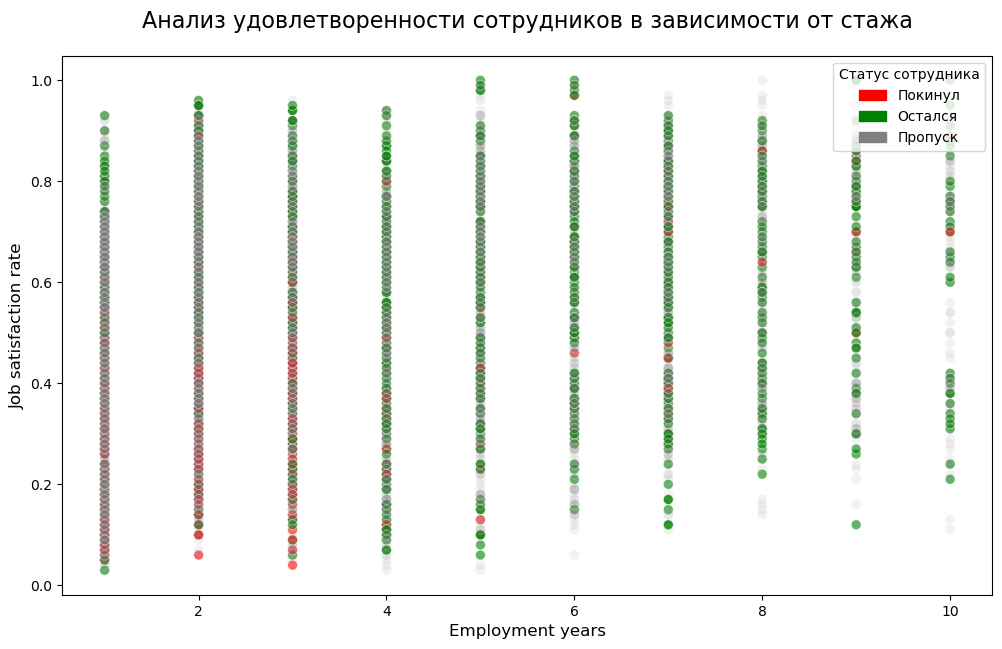

In [31]:
plot_numerical_distribution(
    df, 
    "employment_years", 
    title = "Анализ удовлетворенности сотрудников в зависимости от стажа"
)

- Сотрудники, которые работают в компании более 5 лет очень редко катастрофически неудовлетворены своим рабочим местом.
- При этом заметно, что большое количество сотрудников начинают покидать компанию до 3 лет работы в ней.

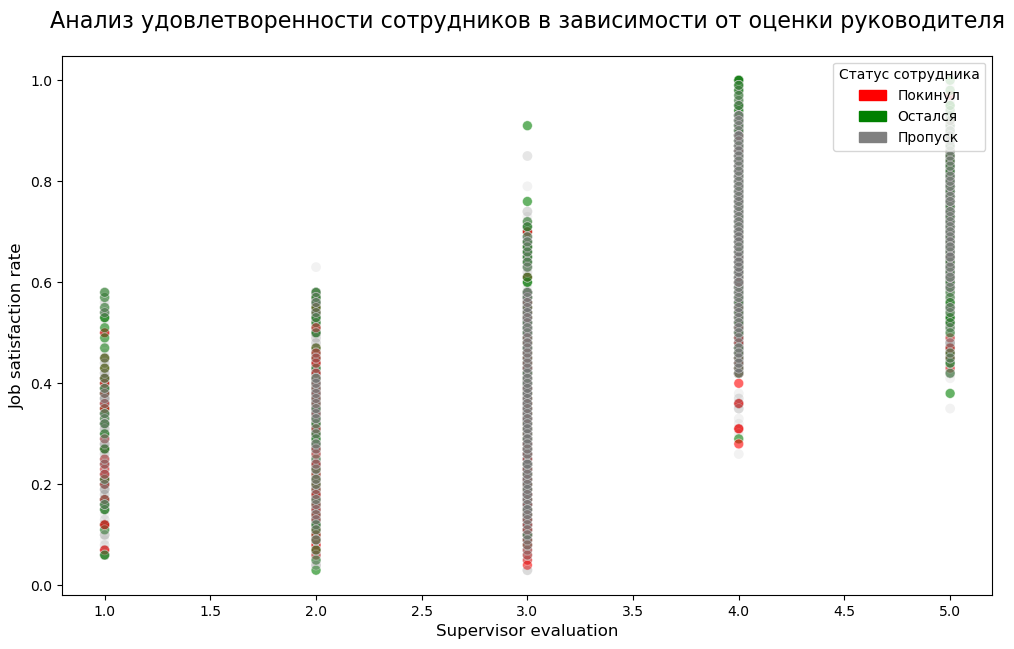

In [32]:
plot_numerical_distribution(
    df, 
    "supervisor_evaluation", 
    title = "Анализ удовлетворенности сотрудников в зависимости от оценки руководителя"
)

- Сотрудники с низкими оценками руководителей менее всего были довольны своей работой и чаще остальных покидали её.
- Для оценок от 3 и выше наблюдается прямая зависимость между удовлетворённостью сотрудника работой и оценкой его руководителя.
- Заметна логичная особенность "сотрудников-хорошистов" с 3 и 4 баллами по оценкам руководителей: при низкой их удовлетворённостю рабочим местом и относительно высоких оценках сотрудники чаще уходили из компании. При высокой же удовлетворённости и таких же оценках руководства "хорошисты" чащё оставались в компании. 

Можно предположить, что позитивные оценки руководства мотивируют сотрудников продолжать работать в компании далее, а негативные воспринимаются как токсичность.


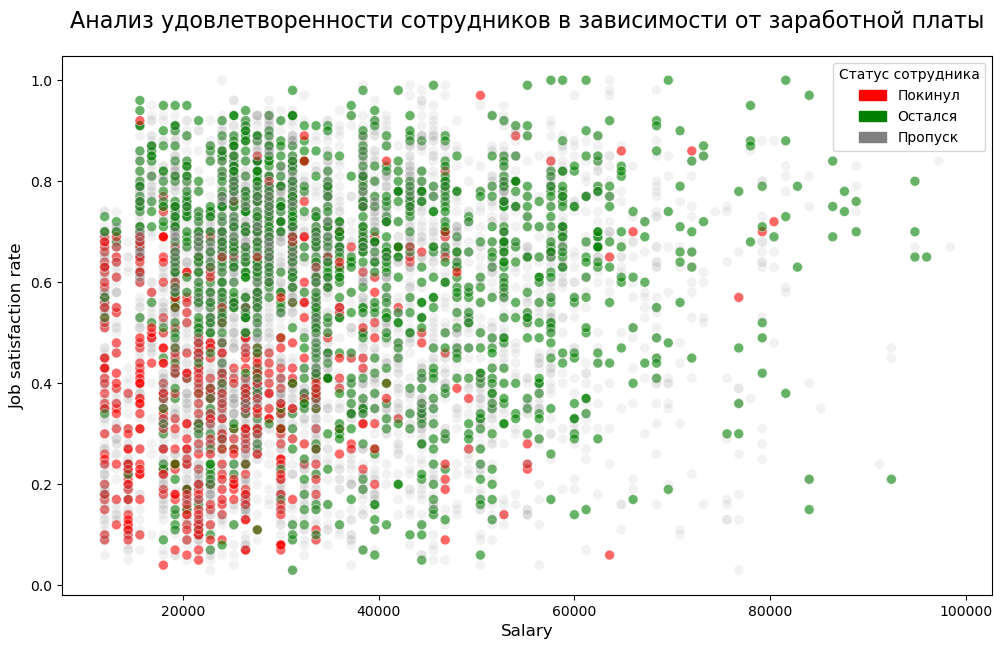

In [33]:
plot_numerical_distribution(
    df, 
    "salary", 
    title = "Анализ удовлетворенности сотрудников в зависимости от заработной платы"
)

- Заметно, что сотрудники с высокой удовлетворённостью рабочим местом чаще всего продолжают работу вне зависимости от их оплаты труда
- Низкая и умеренно-высокая удовлетворённость сотрудников работой в компании при условии оплаты труда менее 40_000 у.е. повышают риски того, что сотрудник прекратит работу в компании
- Заметно, что удовлетворённость сотрудников работой не зависит линейно от оплаты труда

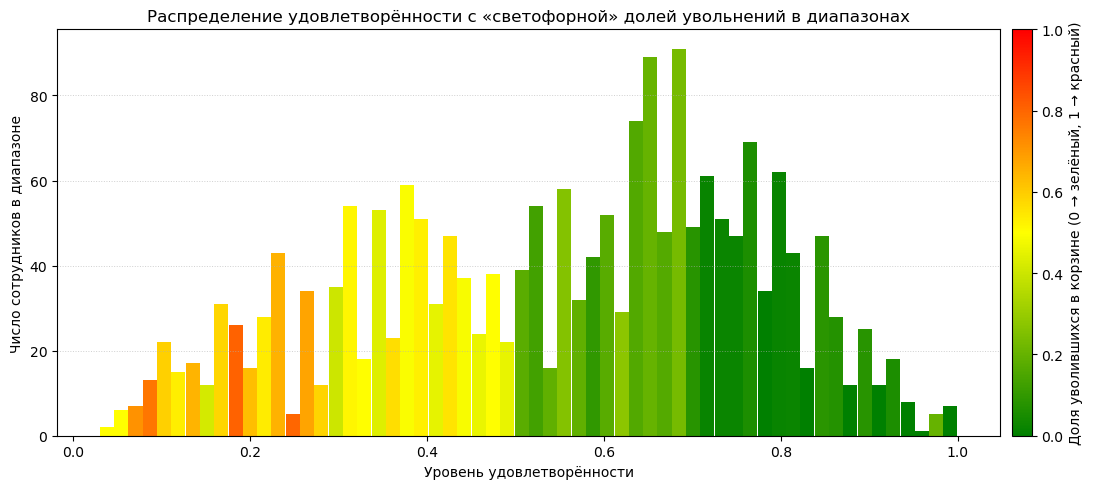

In [34]:
NUM_BINS = 60  

data = df[["job_satisfaction_rate", "quit"]].dropna(subset = ["job_satisfaction_rate", "quit"])
data["quit_bin"] = data["quit"].map({"no": 0.0, "yes": 1.0}).astype("float")

x_min, x_max = data["job_satisfaction_rate"].min(), data["job_satisfaction_rate"].max()
bins = np.linspace(x_min, x_max, NUM_BINS + 1)
bin_widths = np.diff(bins)
bin_centers = (bins[:-1] + bins[1:]) / 2

bin_idx = np.digitize(data["job_satisfaction_rate"].to_numpy(), bins, right = False) - 1
bin_idx = np.clip(bin_idx, 0, NUM_BINS - 1)

counts = np.zeros(NUM_BINS, dtype = int)
quit_mean = np.full(NUM_BINS, np.nan, dtype = float)

for i in range(NUM_BINS):
    mask = (bin_idx == i)
    if np.any(mask):
        counts[i] = mask.sum()
        quit_mean[i] = data.loc[mask, "quit_bin"].mean()

traffic_cmap = LinearSegmentedColormap.from_list("traffic", ["green", "yellow", "red"], N = 256)
norm = Normalize(vmin = 0.0, vmax = 1.0)

colors = traffic_cmap(norm(np.nan_to_num(quit_mean, nan = 0.5)))  

plt.figure(figsize = (12, 5))
plt.bar(bin_centers, counts, width = bin_widths * 0.98, color = colors, edgecolor = "none")

plt.xlabel("Уровень удовлетворённости")
plt.ylabel("Число сотрудников в диапазоне")
plt.title("Распределение удовлетворённости с «светофорной» долей увольнений в диапазонах")
plt.grid(axis = "y", linestyle = ":", linewidth = 0.7, alpha = 0.6)

sm = plt.cm.ScalarMappable(norm = norm, cmap = traffic_cmap)
sm.set_array([])
cbar = plt.colorbar(sm, pad = 0.01)
cbar.set_label("Доля уволившихся в корзине (0 → зелёный, 1 → красный)")

plt.tight_layout()
plt.show()


- Удовлетворённость сотрудника рабочим местом напрямую влияет на прололжение его работы в компании
- Вероятность ухода сотрудника резко падает при удовлетворённости ниже среднего
- График распределения частот удовлетворённости сотрудников мультимодален: неудовлетворённость сотрудников увеливичается до ~0.38 и далее падает до нейтрального уровня удовлетворённости. После нейтрального уровня удовлетворённость сотрудников резко повышается до ~0.7 и далее так же падает
- Чаще всего сотрудники умеренно удовлетворены своим рабочим местом

### Рассмотрим распределения для качественных признаков.

In [35]:
def plot_category_pie_with_satisfaction_rate(
    df: pd.DataFrame,
    category_col: str = "dept",
    satisfaction_col: str = "job_satisfaction_rate",
    top_n: int = 8,
    title: str = "Удовлетворённость работой по департаментам",
    red_hex: str = "#E74C3C",
    green_hex: str = "#2ECC71",
    others_label: str = "Другие",
    others_color: str = "#B0BEC5",
    explode_value: float = 0.05
):
    category_counts = df[category_col].value_counts()
    top_categories = category_counts.head(top_n)
    other_count = int(category_counts.iloc[top_n:].sum())
    has_others = other_count > 0

    if has_others:
        top_categories[others_label] = other_count

    satisfaction_by_cat = (
        df[[category_col, satisfaction_col]]
        .groupby(category_col)[satisfaction_col]
        .mean()
    )
    real_top_cats = [c for c in top_categories.index if c != others_label]
    real_means = satisfaction_by_cat.reindex(real_top_cats)
    vmin = float(np.nanmin(real_means.values)) if len(real_means) else 0.0
    vmax = float(np.nanmax(real_means.values)) if len(real_means) else 1.0

    if np.isclose(vmin, vmax):
        vmin -= 0.5
        vmax += 0.5

    norm = Normalize(vmin = vmin, vmax = vmax)
    cmap = LinearSegmentedColormap.from_list("satisfaction_cmap", ["#F39C12", "#F7DC6F", "#D4E157"])

    colors = []
    for cat in top_categories.index:
        if cat == others_label:
            colors.append(others_color)
        else:
            mean_val = satisfaction_by_cat.get(cat, np.nan)
            colors.append(cmap(norm(mean_val)))

    total = len(df)
    labels = []
    for cat, count in top_categories.items():
        pct = 100 * count / total if total > 0 else 0
        if cat == others_label:
            labels.append(f"{cat}\n({count} чел., {pct:.1f}%)")
        else:
            mean_val = satisfaction_by_cat.get(cat, np.nan)
            sat_txt = "н/д" if pd.isna(mean_val) else f"{mean_val:,.2f}".replace(",", " ")
            labels.append(f"{cat}\n({count} чел., {pct:.1f}% | ср. удовл.: {sat_txt})")

    explode = [explode_value] * len(top_categories)

    fig, ax = plt.subplots(figsize = (18, 10))
    wedges, texts, autotexts = ax.pie(
        top_categories.values,
        labels = labels,
        colors = colors,
        autopct = "%1.1f%%",
        startangle = 90,
        explode = explode,
        shadow = True,
        textprops = {"fontsize": 10, "fontweight": "bold"},
        wedgeprops = dict(linewidth = 1, edgecolor = "white")
    )
    ax.set_title(title, fontsize = 14, fontweight = "bold", pad = 20)
    ax.axis("equal")

    sm = ScalarMappable(norm = norm, cmap = cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax = ax, fraction = 0.046, pad = 0.04, format = mtick.PercentFormatter(1, decimals = 1))
    cbar.set_label("Средняя удовлетворённость сотрудников (по департаменту)", fontsize = 11)

    plt.show()


In [36]:
display(df.dept.value_counts())

sales         2283
technology    1321
purchasing     883
marketing      829
hr             683
                 1
Name: dept, dtype: int64

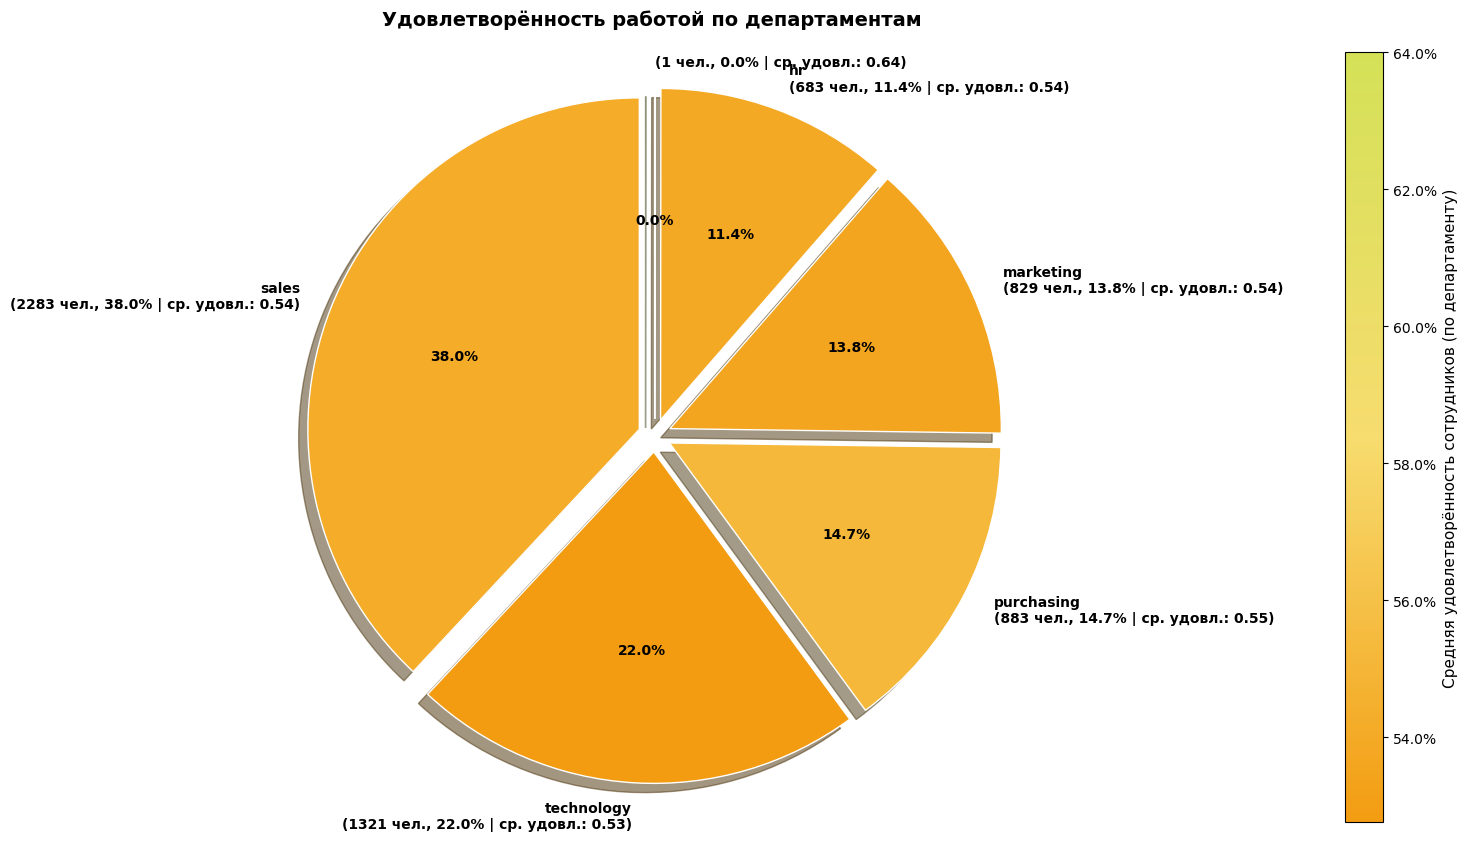

In [37]:
plot_category_pie_with_satisfaction_rate(df)

- Значения удовлетворённости сотрудников во всех департаментах незначительно выше среднего
- Колебания средней удовлетворённости в зависимости от отдела не более 2%
- Наименее удовлетворены работники технологического отдела
- Наиболее удовелетворены работники отдела закупок
- Больше трети сотрудников работают в отделе продаж
- Больше пятой части сотрудников работают в технологическом отделе
- В остальных отделах работает приблизительно равное количество сотрудников
- Наблюдаем пропуски в данных из тестовой выборки, которые будет в последующем устранёны в пайплайне

В целом ясно, что компания занимается продажей товаров т.к. есть отдел закупок. Компания сосредоточила человеческие ресурсы на продажах и IT инфраструктуре для ведения бизнеса. Значительных различий в комфортности работы в различных департаментах не наблюдается

In [38]:
def plot_quit_grouped_bars(
    df: pd.DataFrame,
    category_col: str = "dept",
    ordered_categories: Optional[list] = None,
    quit_col: str = "quit",
    title: str = "Статус сотрудников по категориям",
    x_label: str = "Категория",
    green_hex: str = "#2ECC71",
    red_hex: str = "#E74C3C",
    alpha: float = 0.60,
    width: float = 0.42,
    rotation: int = 0
):
    tmp = df[[category_col, quit_col]].copy()
    tmp["status"] = tmp[quit_col].map({"no": "Остались", "yes": "Ушли"})
    tmp = tmp.dropna(subset = ["status", category_col])

    g = (
        tmp.groupby([category_col, "status"]).size()
        .unstack("status")
        .reindex(columns = ["Остались", "Ушли"])
    )
    if ordered_categories is not None:
        g = g.reindex(ordered_categories)
    g = g.fillna(0).astype(int)

    depts = g.index.tolist()
    stayed_counts = g["Остались"].values if "Остались" in g.columns else np.zeros(len(g))
    quit_counts = g["Ушли"].values if "Ушли" in g.columns else np.zeros(len(g))
    totals = stayed_counts + quit_counts
    stay_share = np.divide(stayed_counts, totals, out = np.zeros_like(stayed_counts, dtype = float), where = totals > 0) * 100.0
    quit_share = np.divide(quit_counts, totals, out = np.zeros_like(quit_counts, dtype = float), where = totals > 0) * 100.0
    x = np.arange(len(depts))

    fig, ax = plt.subplots(figsize = (18, 9))
    bars_stay = ax.bar(x - width / 2, stayed_counts, width, label = "Остались", color = green_hex, alpha = alpha)
    bars_quit = ax.bar(x + width / 2, quit_counts, width, label = "Ушли", color = red_hex, alpha = alpha)

    ax.bar_label(bars_stay, labels = [f"{v:.1f}%" for v in stay_share], padding = 3, fontsize = 9, fontweight = "bold")
    ax.bar_label(bars_quit, labels = [f"{v:.1f}%" for v in quit_share], padding = 3, fontsize = 9, fontweight = "bold")
    ax.set_xticks(x)
    ax.set_xticklabels(depts, rotation = rotation, ha = "center")
    ax.set_xlabel(x_label, fontsize = 12)
    ax.set_ylabel("Количество сотрудников", fontsize = 12)
    ax.set_title(title, fontsize = 14, fontweight = "bold", pad = 12)
    ax.grid(axis = "x", linestyle = "--", linewidth = 0.8, alpha = 0.8)
    ax.legend(frameon = False)

    fig.tight_layout()
    plt.show()


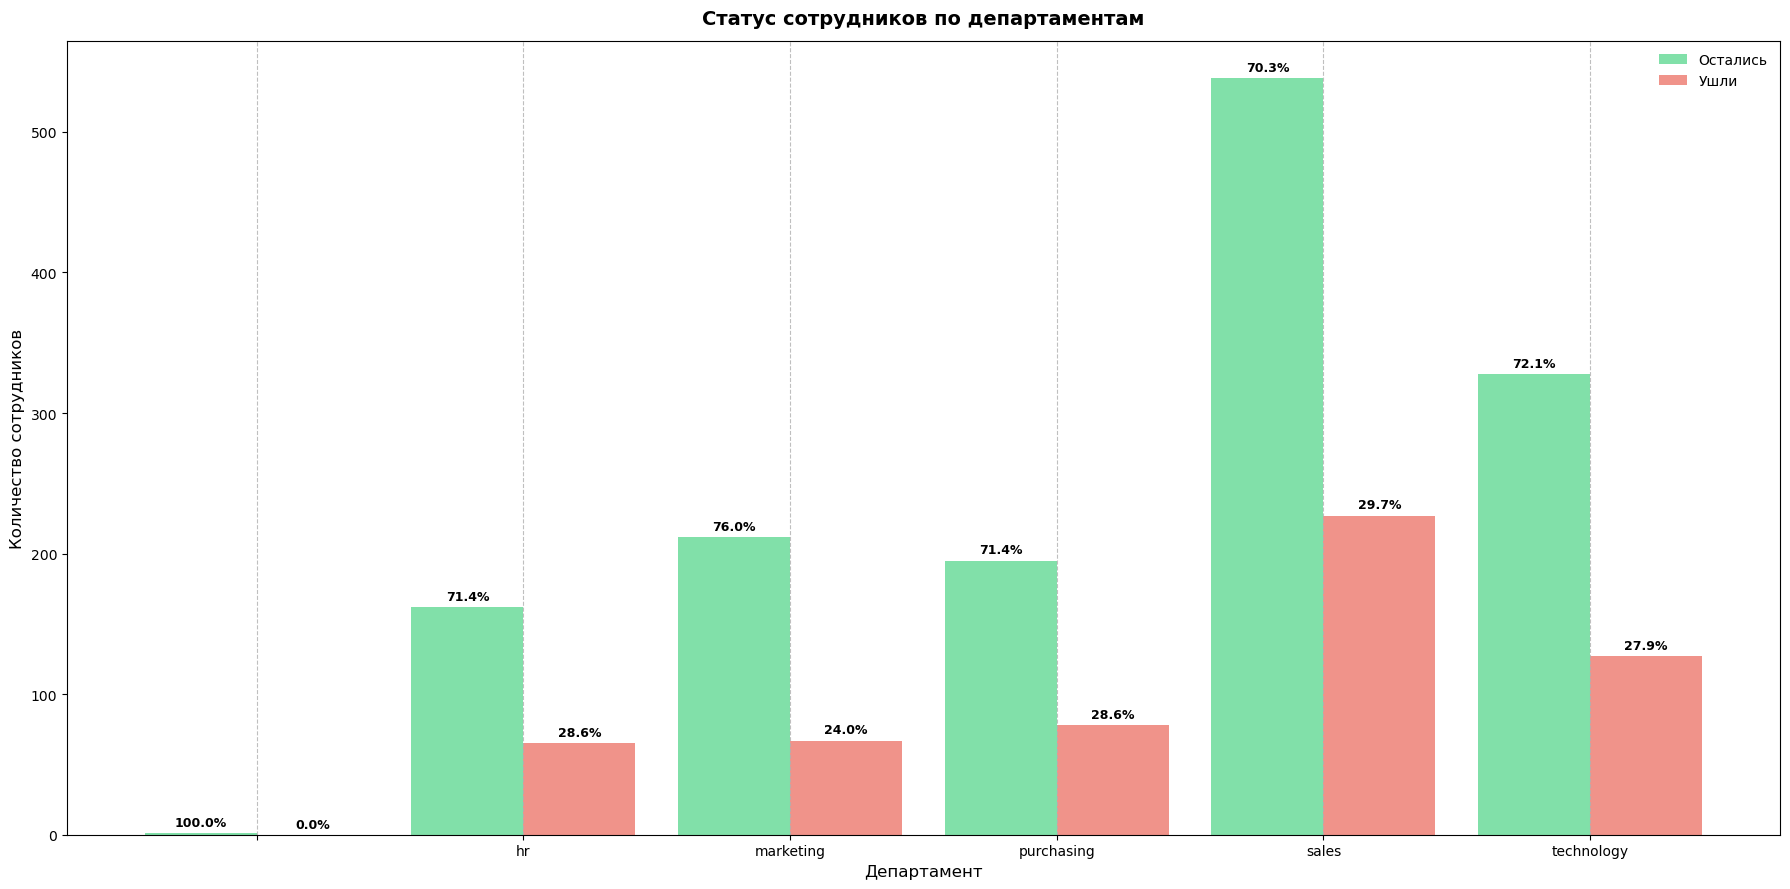

In [39]:
plot_quit_grouped_bars(df,
    title = "Статус сотрудников по департаментам",
    x_label = "Департамент")

- Больше всего сотрудников уходит и в абсолютном (200+ человек) и в относительном (29.5%) смысле из отдела продаж
- Меньше всего сотрудников в относительном смысле уходит из отдела маркетинга (24.1%)
- В любом из отделов примерно каждый четвёртый сотрудник покидает команду
- Разница между долей покинувших рабочее место сотрудников в лучшем и худшем департаменте составляет 5.4%
- Наблюдаем пропуски в данных из тестовой выборки, которые будет в последующем устранёны в пайплайне

Текучка кадров в отделе продаж на допустимом уровне и на мой взгляд обусловлена спецификой работы в продажах.

In [40]:
def plot_ordered_category_bars(
    df: pd.DataFrame,
    category_col: str,
    ordered_categories: list,
    satisfaction_col: str = "job_satisfaction_rate",
    title: str = "Распределение сотрудников по категориям и удовлетворённости",
    x_label: str = "Категория",
    greenish_yellow_hex: str = "#D4E157",
    yellow_hex: str = "#F7DC6F",
    reddish_yellow_hex: str = "#F39C12",
    width: float = 0.7,
    alpha: float = 0.8,
    show_colorbar: bool = True
):
    counts = df.groupby(category_col).size().reindex(ordered_categories, fill_value = 0)
    means = df.groupby(category_col)[satisfaction_col].mean().reindex(ordered_categories)
    vals = means.values.astype(float)
    if np.all(np.isnan(vals)):
        vmin, vmax = 0.0, 1.0
    else:
        vmin = float(np.nanmin(vals))
        vmax = float(np.nanmax(vals))
    if np.isclose(vmin, vmax):
        vmin -= 0.5
        vmax += 0.5

    norm = Normalize(vmin = vmin, vmax = vmax)
    cmap = LinearSegmentedColormap.from_list("yellow_satisfaction", [reddish_yellow_hex, yellow_hex, greenish_yellow_hex])

    colors = []
    for m in means.values:
        if pd.isna(m):
            colors.append(yellow_hex)
        else:
            colors.append(cmap(norm(m)))

    total = float(counts.sum())
    pct_share = (counts.values.astype(float) / total * 100.0) if total > 0 else np.zeros_like(counts.values, dtype = float)

    x = np.arange(len(ordered_categories))
    fig, ax = plt.subplots(figsize = (16, 9))
    bars = ax.bar(x, counts.values.astype(float), width = width, color = colors, edgecolor = "white", linewidth = 1, alpha = alpha)

    ax.bar_label(bars, labels = [f"{v:.1f}%" for v in pct_share], padding = 3, fontsize = 9, fontweight = "bold")
    ax.set_xticks(x)
    ax.set_xticklabels(ordered_categories)
    ax.set_xlabel(x_label, fontsize = 12)
    ax.set_ylabel("Количество сотрудников", fontsize = 12)
    ax.set_title(title, fontsize = 14, fontweight = "bold", pad = 14)
    ax.grid(axis = "y", linestyle = "--", linewidth = 0.8, alpha = 0.5)
    ax.margins(x = 0.02)

    if show_colorbar:
        sm = ScalarMappable(norm = norm, cmap = cmap)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax = ax, fraction = 0.046, pad = 0.04, format = mtick.PercentFormatter(1, decimals = 1))
        cbar.set_label("Средняя удовлетворённость (по категории)", fontsize = 11)

    fig.tight_layout()
    plt.show()


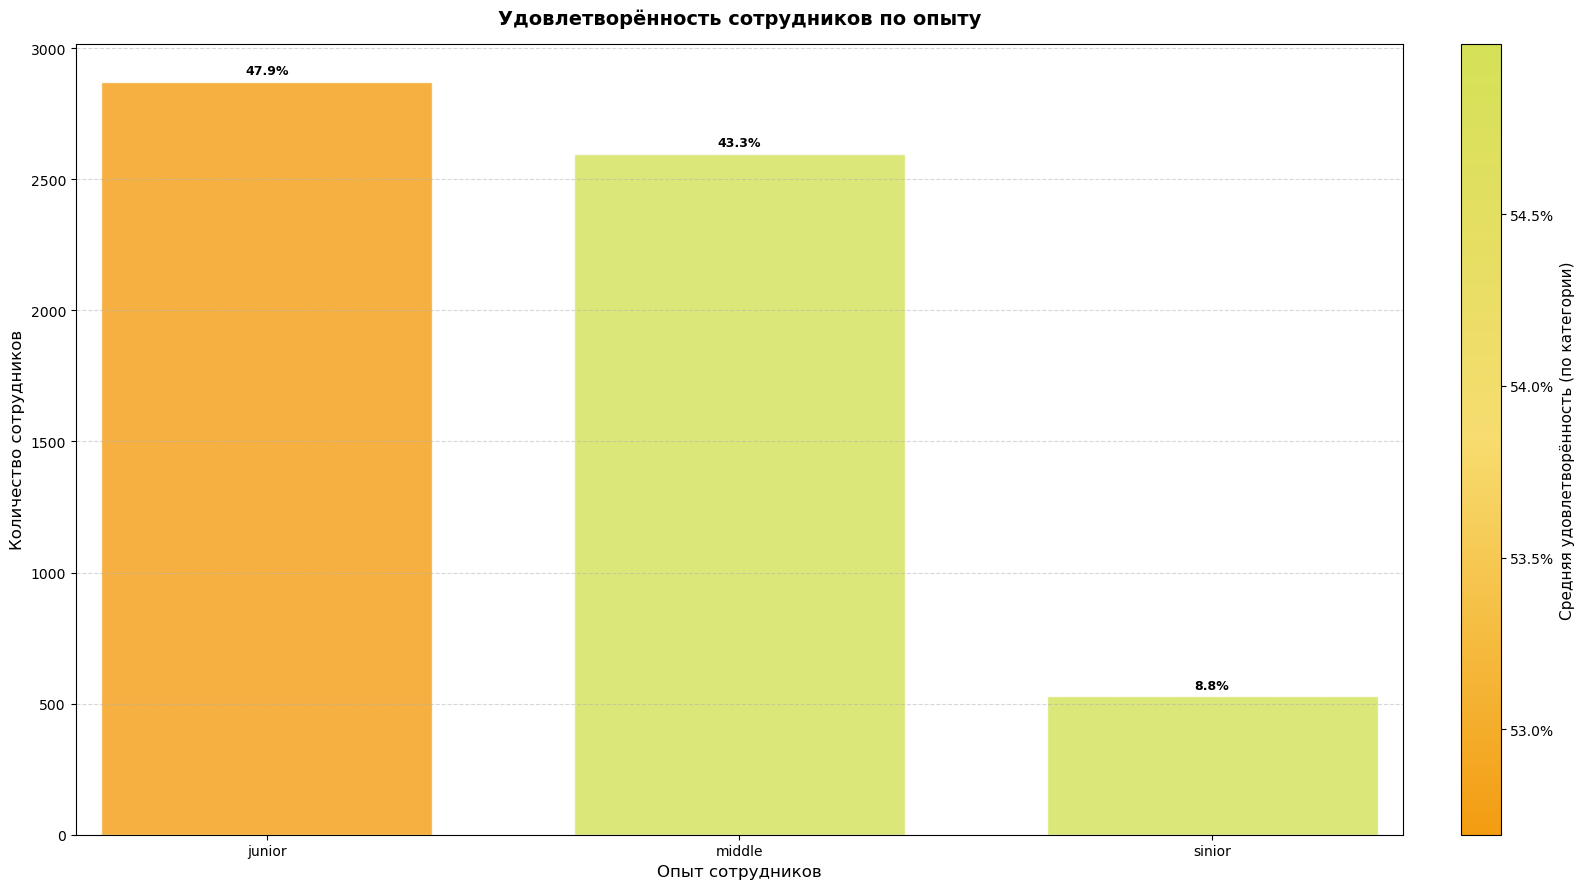

In [41]:
plot_ordered_category_bars(df,
    category_col = "level",
    ordered_categories = ["junior", "middle", "sinior"],
    title = "Удовлетворённость сотрудников по опыту",
    x_label = "Опыт сотрудников")

- Опытных сотрудников в компании более чем в 10 раз меньше, чем новичков и бывалых
- Новичков незначительно больше чем бывалых сотрудников
- Меньше всего довольны рабочими местами новички

Стоит лучше продумать процесс адаптации новых сотрудников т.к. среди них больше всего недовольных работой людей

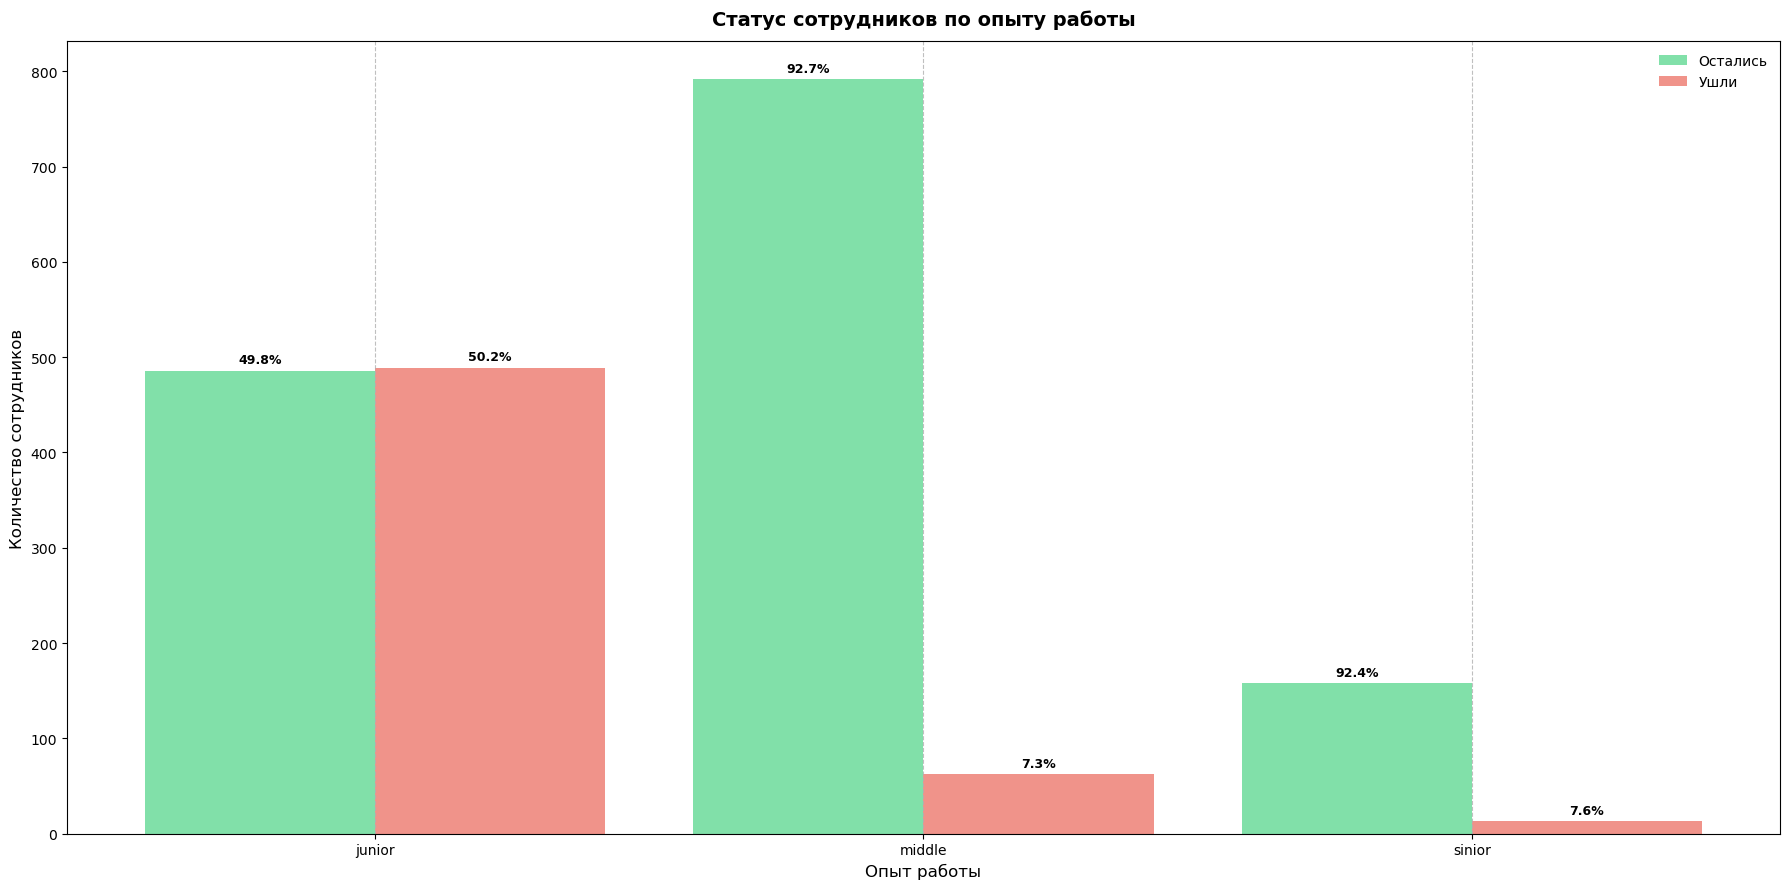

In [42]:
plot_quit_grouped_bars(df,
    category_col = "level",
    ordered_categories = ["junior", "middle", "sinior"],
    title = "Статус сотрудников по опыту работы",
    x_label = "Опыт работы")

- Чуть более половины новичков в профессии покидает компанию
- Доля опытных специалистов покидающих компанию более чем в 7 раз меньше и составляет чуть более 7%

В целом, адекватные показатели текучки с учётом испытательных сроков и низкой текучки опытных сотрудников

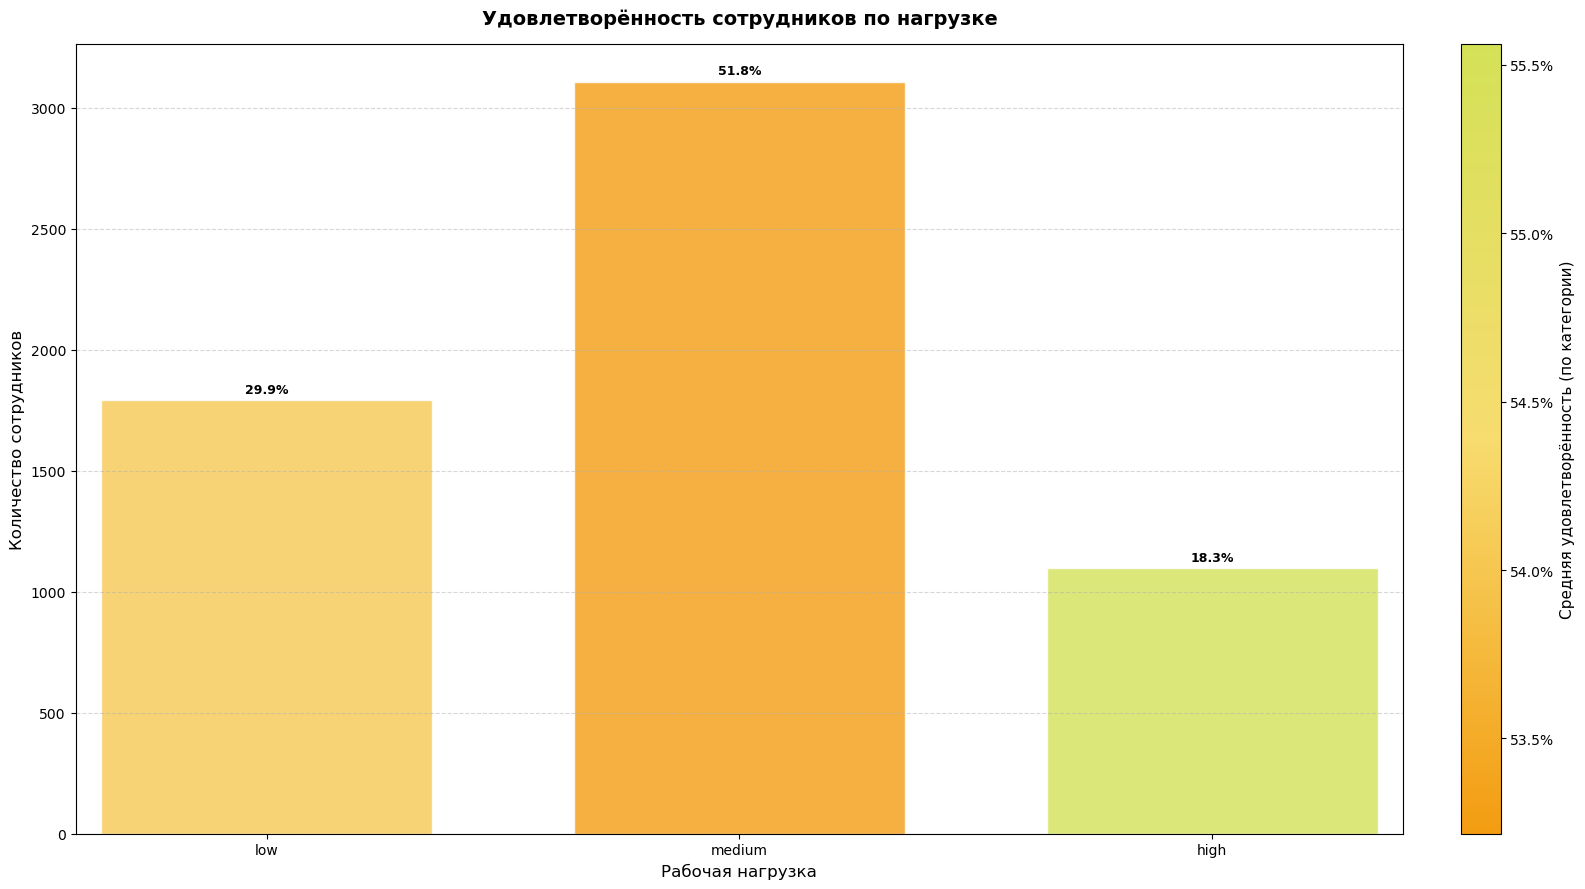

In [43]:
plot_ordered_category_bars(df,
    category_col = "workload",
    ordered_categories = ["low", "medium", "high"],
    title = "Удовлетворённость сотрудников по нагрузке",
    x_label = "Рабочая нагрузка")

- Парадоксально, но ~20% сотрудников, оценивших свою нагрузку как высокую более довольны своим местом работы в среднем
- ~50% сотрудников, имеющих среднюю нагрузку в среднем меньше всего довольны своим местом работы
- ~30% сотрудников недогружены, есть потенциал к повышению производительности труда

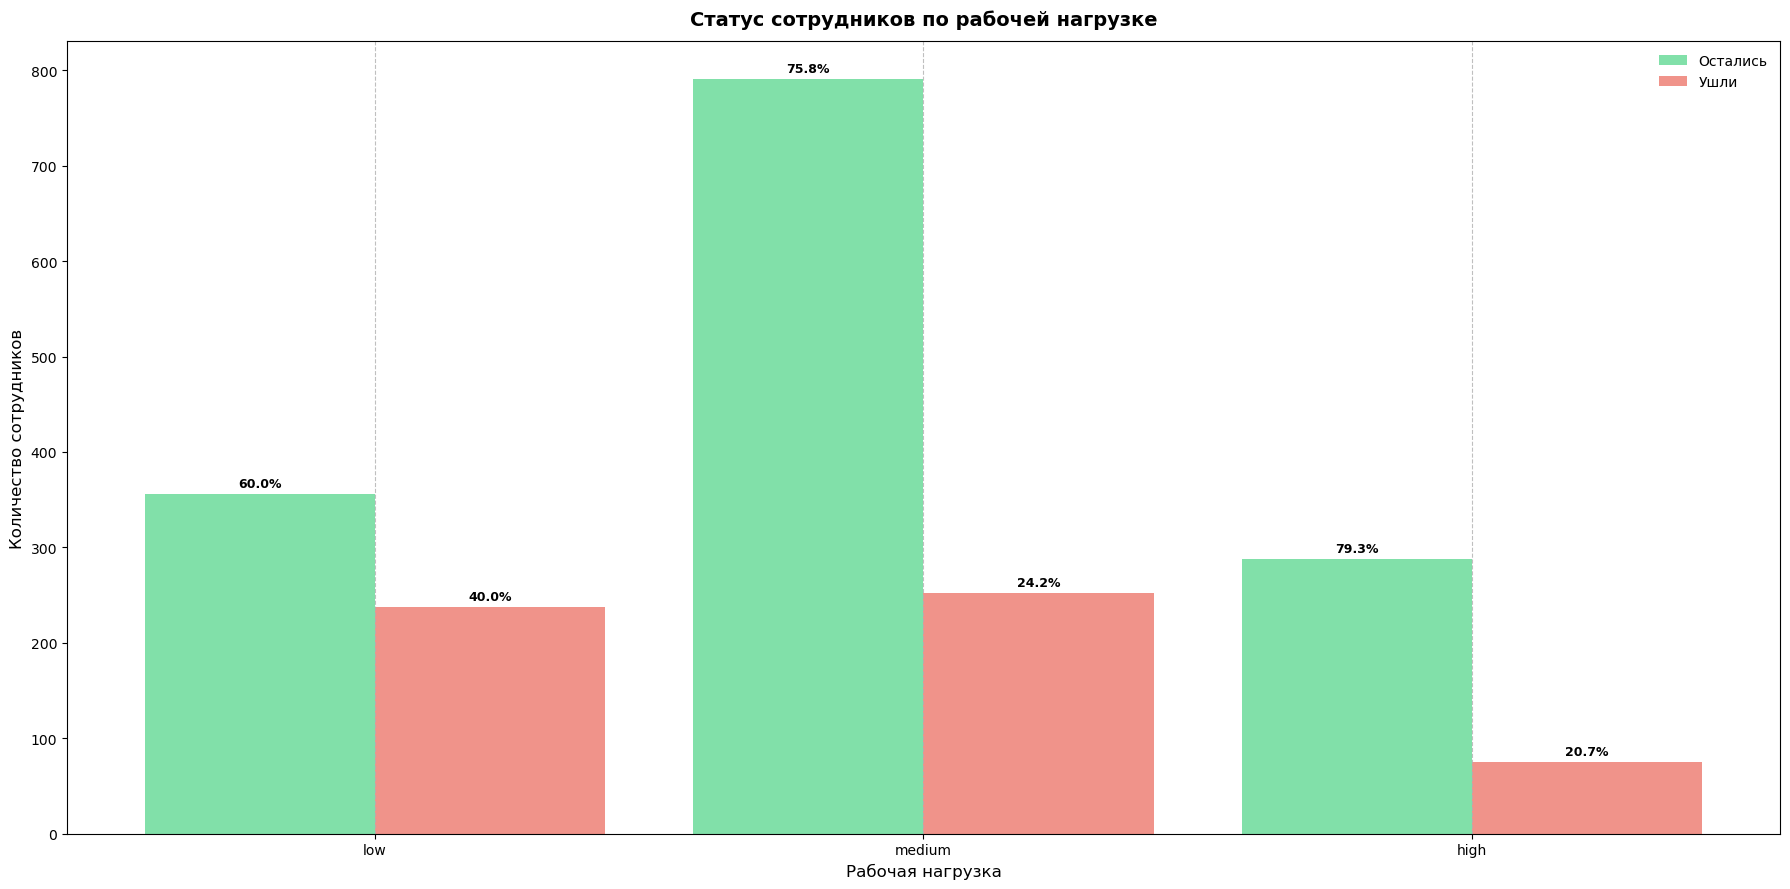

In [44]:
plot_quit_grouped_bars(df,
    category_col = "workload",
    ordered_categories = ["low", "medium", "high"],
    title = "Статус сотрудников по рабочей нагрузке",
    x_label = "Рабочая нагрузка")

Схожая с удовлетворённостью ситуация:

- Работники с низким уровнем нагрузки в 40% случаев покидают работу
- Работники с высоким уровнем нагрузки в 2 реже покидают работу, чем малонагруженные коллеги
- Четверть сотрудников со средним уровнем нагрузки покидает компанию

Высокий уровень нагрузки, вероятно, воспринимается сотрудниками как интересные вызовы и возможность развития, HR департаменту стоит детальнее изучить этот вопрос в рамках компании

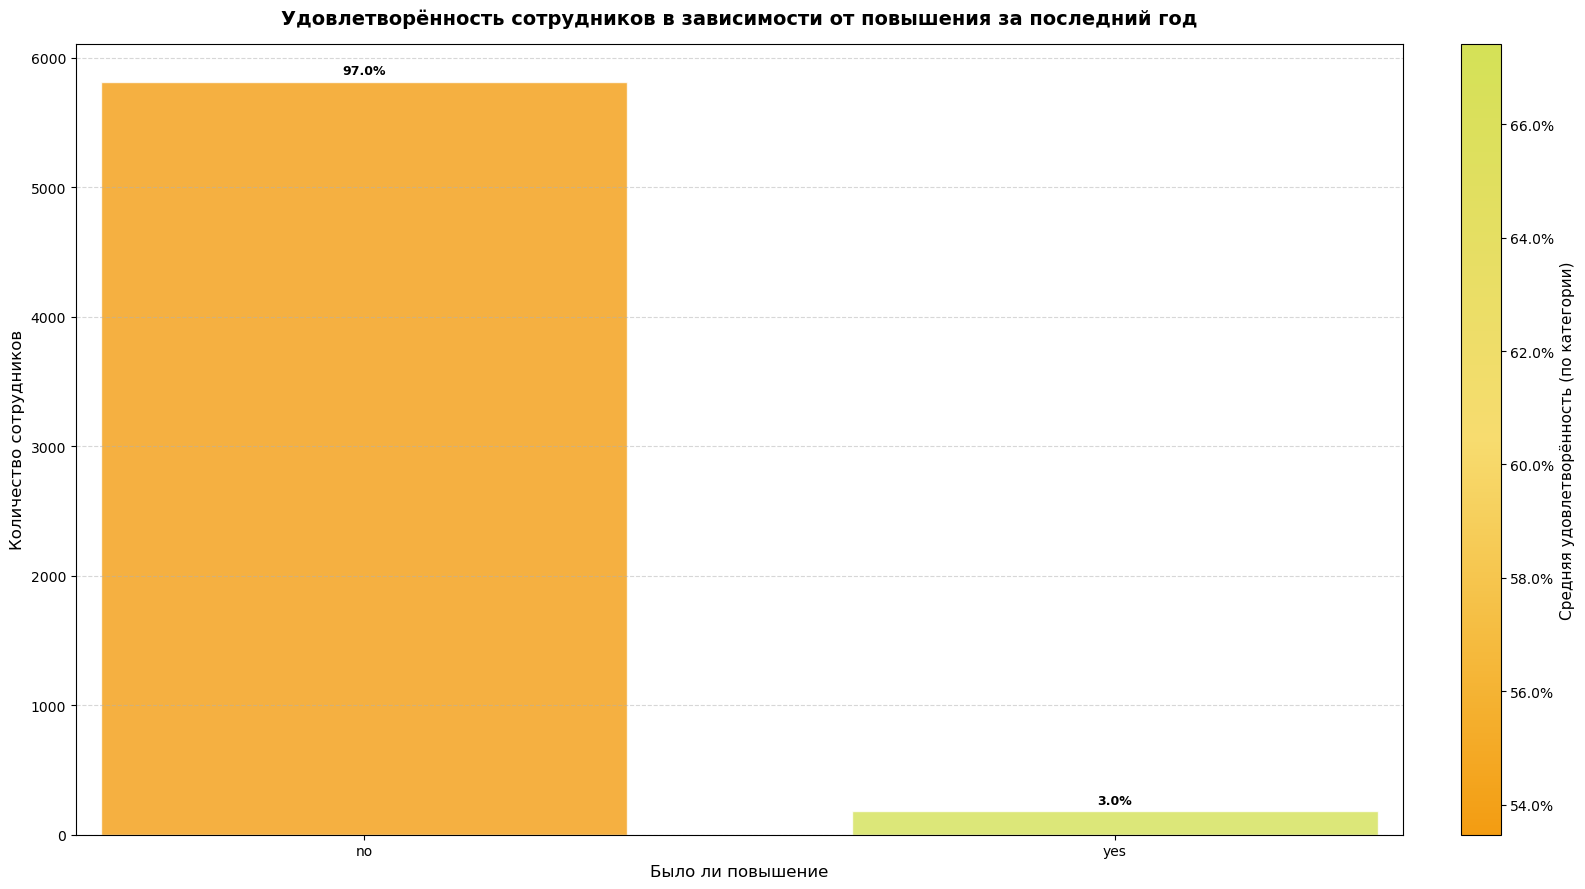

In [45]:
plot_ordered_category_bars(df,
    category_col = "last_year_promo",
    ordered_categories = ["no", "yes"],
    title = "Удовлетворённость сотрудников в зависимости от повышения за последний год",
    x_label = "Было ли повышение")

- Сотрудников, получивших повышение в 33 раза меньше
- Повышение значительно влияет на удовлетворённость сотрудников работой 

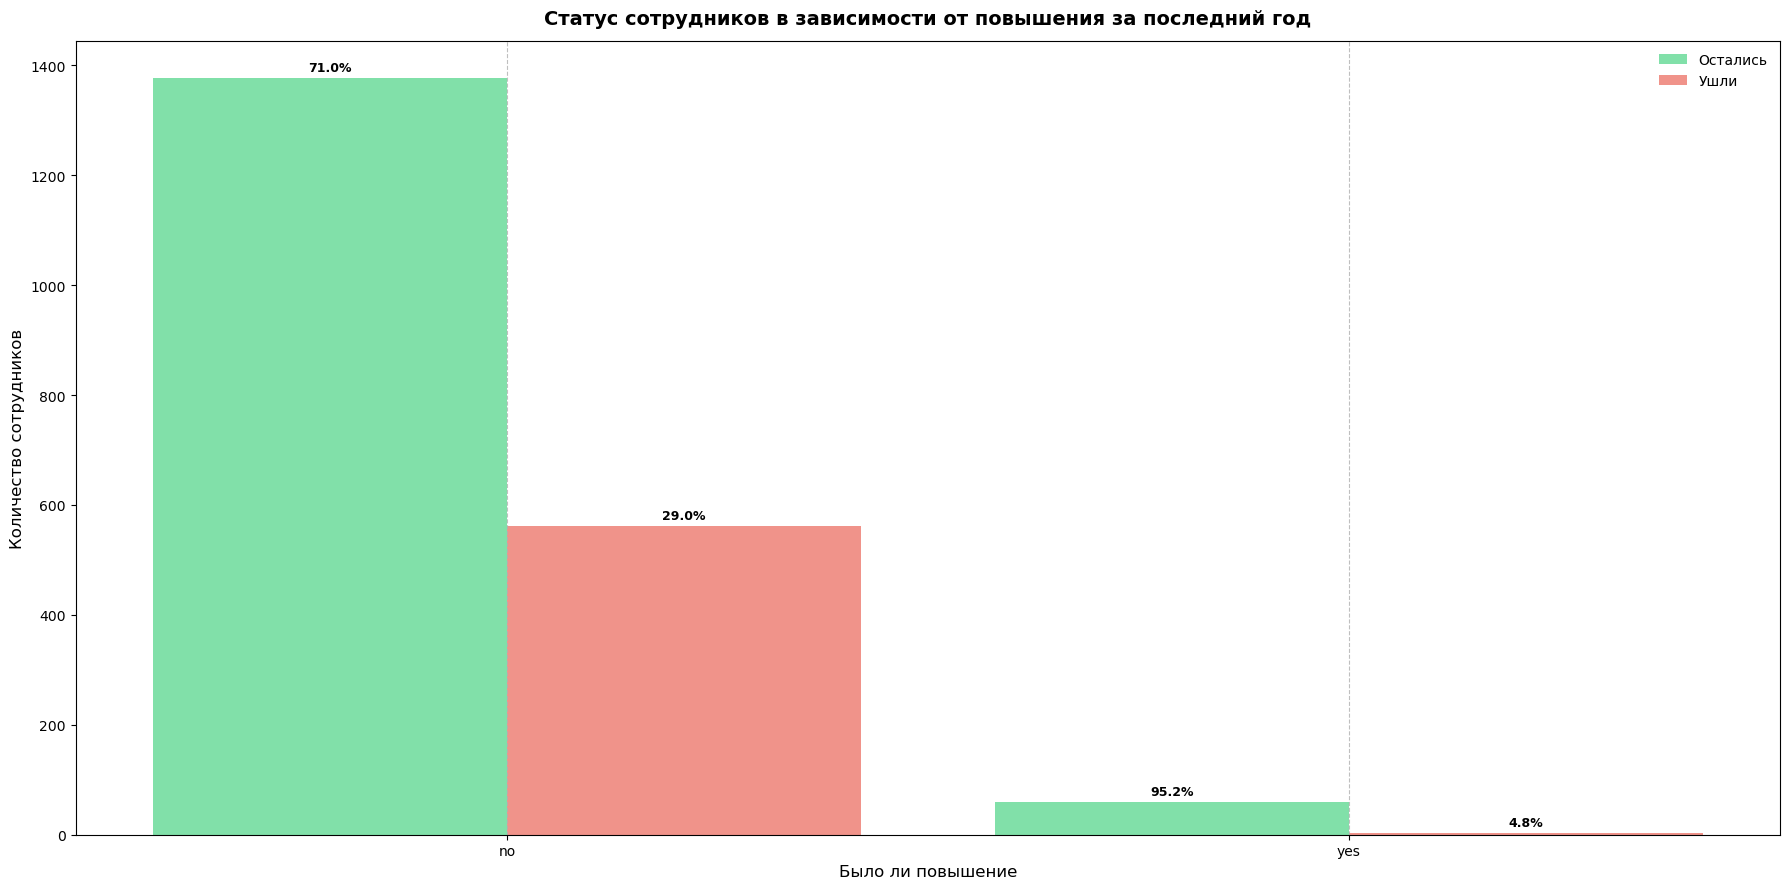

In [46]:
plot_quit_grouped_bars(df,
    category_col = "last_year_promo",
    title = "Статус сотрудников в зависимости от повышения за последний год",
    x_label = "Было ли повышение")

- Большинство сотрудников не получали повышения
- Повышение в 6 раз уменьшает вероятность покидания сотрудником рабочего места

Есть смысл чаще мотивировать сотрудников, давая им незначительные повышения, как одну из стратегий удержания человеческого капитала в компании

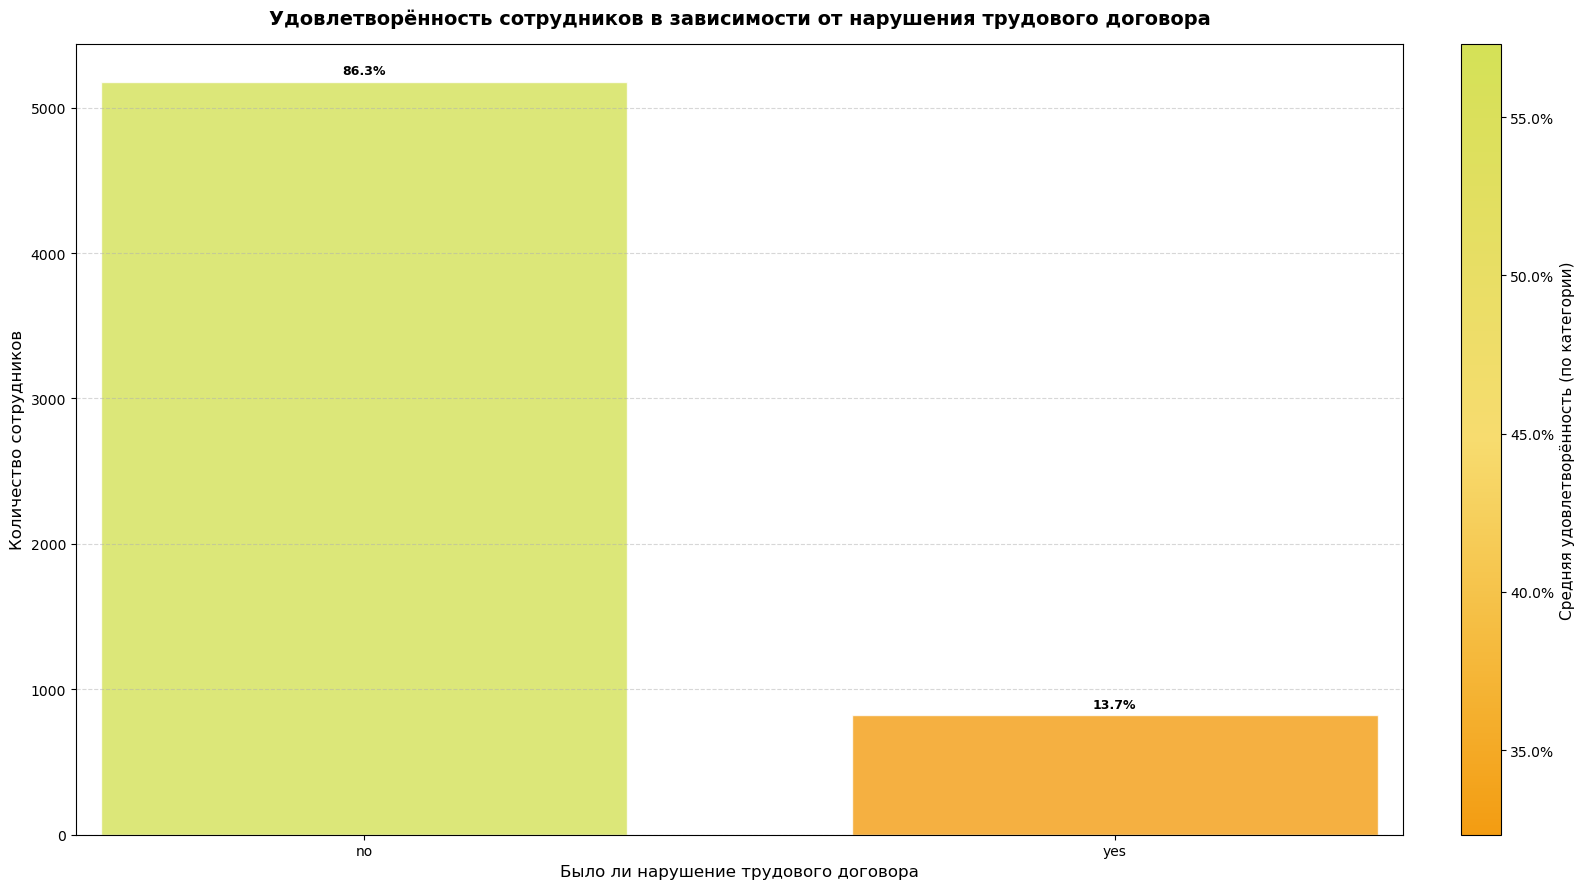

In [47]:
plot_ordered_category_bars(df,
    category_col = "last_year_violations",
    ordered_categories = ["no", "yes"],
    title = "Удовлетворённость сотрудников в зависимости от нарушения трудового договора",
    x_label = "Было ли нарушение трудового договора")

- Нарушивших трудовой договор более чем в раз меньше
- Удовлетворённость работой нарушивших трудовой договор значительно меньше, чем у остальных сотрудников

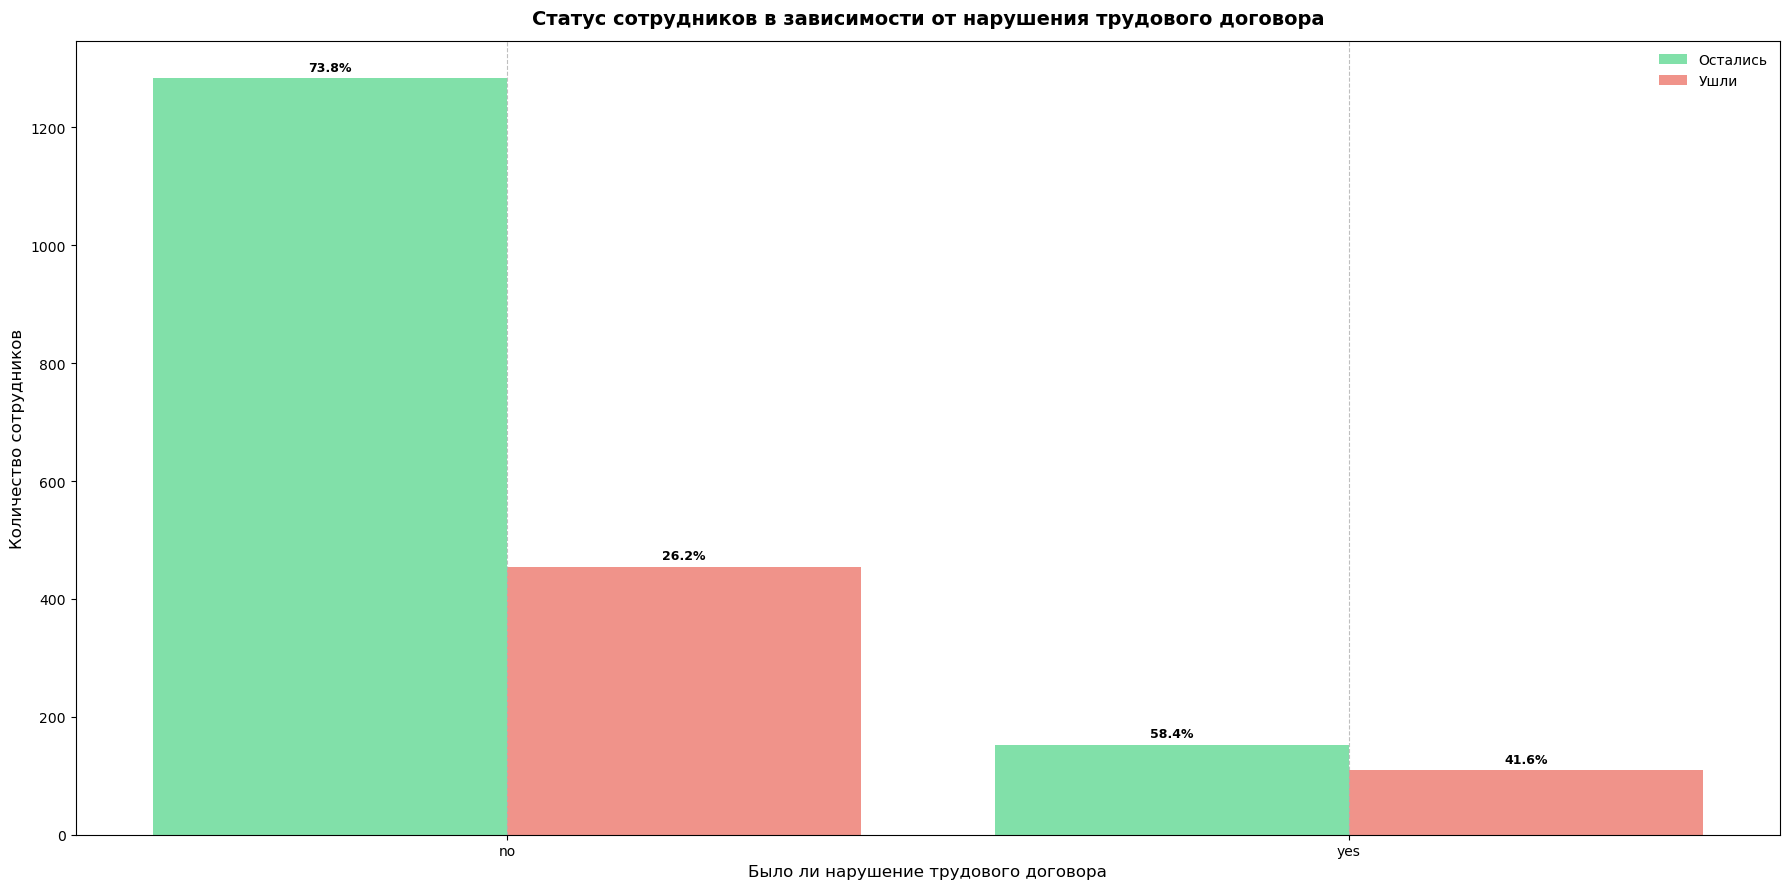

In [48]:
plot_quit_grouped_bars(df,
    category_col = "last_year_violations",
    title = "Статус сотрудников в зависимости от нарушения трудового договора",
    x_label = "Было ли нарушение трудового договора")

- Сотрудники, нарушившие трудовой договор почти в 2 раза чаще покидали компанию

Возможно, HR отделу стоит внимательнее изучить причинно-следственную связь между нарушением трудового договора и удовлетворённостью рабочим местом сотрудников компании. Появилась гипотеза, что низкая удовлетворённость работой в компании может быть причиной нарушения трудового договора и последующего покидания рабочего места в некоторых случаях

### Выводы EDA

**Промежуточный вывод**:

Провели ознакомление с данными сотрудников, значительных выбросов и аномалий найдено не было, сделали выводы о влиянии признаков на целевые показатели.

Сотрудник, вероятно, покинет компанию если:

- Сотрудники реже увольняются после 4 лет работы в компании
- Позитивные оценки руководства выше среднего позитивно влияют на удовлетворённость работой сотрудников
- Сотрудникам с высокой удовлетворённостью рабочим местом можно не повышать ЗП т.к. они с высокой вероятностью останутся. При этом недовольные сотрудники с ЗП ниже 40_000 скорее всего уйдут
- Важно следить за тем, чтобы удовлетворённость сотрудника работой оставалась выше 50% т.к. это резко понижает шансы ухода
- Значительных различий в комфортности работы в различных департаментах не наблюдается
- Стоит обратить внимание на текучку кадров в отделе продаж 
- Стоит лучше продумать процесс адаптации новых сотрудников т.к. среди них больше всего недовольных работой людей
- Сотрудникам стоит давать более сложные задачи т.к. это понижает вероятность ухода и одновременно может повысить производительность труда
- Появилась гипотеза, что низкая удовлетворённость работой в компании может быть причиной нарушения трудового договора и последующего покидания рабочего места в некоторых случаях. HR отделу стоит детальнее изучить этот процес в динамике
- Есть смысл чаще мотивировать сотрудников, давая им незначительные повышения, как одну из стратегий удержания человеческого капитала в компании

## Корреляционный анализ

### Корреляционная матрица

Для начала построим кореляционную матрицу в виде тепловой карты.

interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


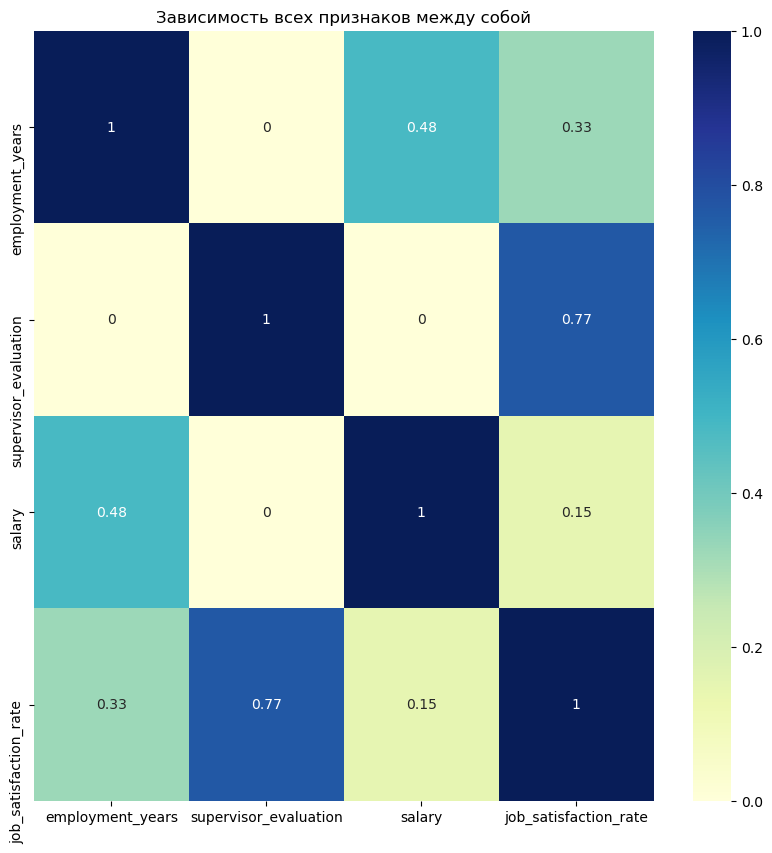

In [49]:
numeric_columns = df.select_dtypes(include = ["number"]).columns.tolist()
numeric_columns.remove("id")
fig, ax = plt.subplots(figsize=(10,10))  
phi_k = df[numeric_columns].phik_matrix()
sns.heatmap(phi_k, cmap = "YlGnBu", annot = True)
ax.set_title("Зависимость всех признаков между собой")
plt.show()

### VIF (коэффициент инфляции дисперсии)

Оценим мультиколлинеарность каждого не содержащего пропусков численного признака в данных при помощи рассчёта коэффициента инфляции дисперсии

In [50]:
X = add_constant(df[numeric_columns])
VIFs = pd.DataFrame()
VIFs["Variable"] = X.columns
VIFs["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

display(VIFs.sort_values(by = "VIF", ascending = False))

,Variable,VIF
0,const,18.233315
4,job_satisfaction_rate,2.119877
2,supervisor_evaluation,2.023674
1,employment_years,1.354461
3,salary,1.277115


Исходя из корелляционной матрицы и анализа VIF делаем вывод, что мультиколлинеарность в данных отсутствует. Наиболее скоррелированным с целевым признаком является оценка руководителя.

## Построение пайплайнов

### Подготовка данных

На данном этапе в подготовке данных к ML нужно учитывать, что в данных могут присутствовать некорректные категории. Например, символ пробела, встреченный во время предобработки или иные. Для обработки таких значениё без искажения предсказаний будем игнорировать такие значения и присваивать им нулевые веса.

In [51]:
y_train = X_train["job_satisfaction_rate"]
X_train = X_train.drop(["id", "job_satisfaction_rate"], axis = 1)

ohe_columns = ["dept", "last_year_promo", "last_year_violations"]
ord_columns = ["level", "workload"]
numeric_columns = X_train.select_dtypes(include = ["number"]).columns.tolist()

cat_ohe_pipe = Pipeline([
    ("impute", SimpleImputer(strategy = "most_frequent")),
    ("ohe", OneHotEncoder(drop = "if_binary",
                          handle_unknown = "ignore"))
])

cat_ord_pipe = Pipeline([
    ("impute", SimpleImputer(strategy = "most_frequent")),
    ("ord", OrdinalEncoder(handle_unknown = "use_encoded_value",
                           unknown_value = np.nan))
])

num_pipe = Pipeline([
    ("impute", SimpleImputer(strategy = "mean")),
    ("scale", MinMaxScaler())
])

data_preprocessor = ColumnTransformer(
    transformers=[
        ("cat_ohe", cat_ohe_pipe, ohe_columns),
        ("cat_ord", cat_ord_pipe, ord_columns),
        ("num", num_pipe, numeric_columns),
    ],
    remainder="drop"
)

### Cоздаём итоговый пайплайн: перебор методов подготовки данных и моделей регрессии с разными гиперпараметрами

In [52]:
regress_pipe = Pipeline([
    ("preprocessor", data_preprocessor),
    ("models", LinearRegression(n_jobs = -1, copy_X = True))
])

param_grid = [
    {
        'models': [LinearRegression(n_jobs = -1, copy_X = True)],
        'preprocessor__num__scale': [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler(), 'passthrough']  
    },
    {
        "models": [KNeighborsRegressor(n_jobs = -1)],
        "models__n_neighbors": range(2, 7),
        "models__weights": ["uniform", "distance"],
        "models__algorithm": ["ball_tree", "kd_tree"],
        "models__leaf_size": range(2, 51, 3),
        "models__metric": ["euclidean", "manhattan"],
        "preprocessor__num__scale": [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler(), "passthrough"]   
    },
    {
        "models": [ElasticNet(
            random_state=RANDOM_STATE, 
            copy_X = True
        )],
        "models__alpha": [.5, 1, 2, 5, 10],
        "models__l1_ratio": [.4, .5, .6],
        "preprocessor__num__scale": [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler(), "passthrough"]  
    },
    {
        "models": [SVR()],
        "models__C": [1, 2, 4, 8, 16, 32],
        "models__kernel": ["linear", "poly", "rbf", "sigmoid"],
        "models__degree": [2, 3, 4, 5],
        "models__gamma": ["scale", "auto"],
        "preprocessor__num__scale": [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler(), "passthrough"]  
    },
    {
        "models": [DecisionTreeRegressor(
            random_state=RANDOM_STATE
        )],
        "models__criterion": ["squared_error", "friedman_mse", "absolute_error", "poisson"],
        "models__max_depth": range(2, 11),
        "models__min_samples_split": range(2, 10),
        "models__min_samples_leaf": range(2, 51, 2),
        "models__max_features": ["sqrt", "log2"],
        "preprocessor__num__scale": [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler(), "passthrough"]  
    }
]

def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype = float)
    y_pred = np.asarray(y_pred, dtype = float)
    denom = np.abs(y_true) + np.abs(y_pred)
    ratio = np.where(denom == 0.0, 0.0, np.abs(y_true - y_pred) / (denom / 2.0))
    return 100.0 * np.mean(ratio)

smape_scorer = make_scorer(smape, greater_is_better = False) 

randomized_search = RandomizedSearchCV(
    regress_pipe, 
    param_grid,
    n_iter = 30,
    cv = 5,
    scoring = smape_scorer,
    random_state = RANDOM_STATE,
    n_jobs = -1
)

randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('cat_ohe',
                                                                               Pipeline(steps=[('impute',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='if_binary',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('cat_ord',
                                                                               Pipeline(steps=[('impute',
                                                                                                SimpleImputer(strate...
                                                               'absolute_error',
                                                               'poisson'],
                                         'models__max_depth': range(2, 11),
                                         'models__max_features': ['sqrt',
                                                                  'log2'],
                                         'models__min_samples_leaf': range(2, 51, 2),
                                         'models__min_samples_split': range(2, 10),
                                         'preprocessor__num__scale': [StandardScaler(),
                                                                      MinMaxScaler(),
                                                                      RobustScaler(),
                                                                      MaxAbsScaler(),
                                                                      'passthrough']}],
                   random_state=1,
                   scoring=make_scorer(smape, greater_is_better=False))

### Выбор метрики

Для задачи выбрана метрика SMAPE по желанию заказчика.

In [53]:
display("Лучшая модель и её параметры:\n\n", randomized_search.best_estimator_)
display ("Метрика лучшей модели на тренировочной выборке:", randomized_search.best_score_)

y_test_pred = randomized_search.predict(X_test)

display(f"Метрика SMAPE на тестовой выборке: {smape(y_test_regress, y_test_pred)}")

'Лучшая модель и её параметры:\n\n'

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat_ohe',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('cat_ord',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan))]),
                                                  ['level', 'workload']),
                                                 ('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['employment_years',
                                                   'supervisor_evaluation',
                                                   'salary'])])),
                ('models',
                 DecisionTreeRegressor(max_depth=10, max_features='log2',
                                       min_samples_leaf=2, random_state=1))])

'Метрика лучшей модели на тренировочной выборке:'

-19.160850886049463

c:\Users\yka\AppData\Local\anaconda3\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


ValueError: Input X contains NaN.
DecisionTreeRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

### Вывод подбора модели

**Наилучшей** моделью оказалась **модель ближайших соседей** с количеством рассматритваемых соседей 4 и расстоянием считаемым по манхеттенской метрике со значением метрики **ROC AUC близким к 0.88** на тестовой выборке. Такое значение точности выглядит правдоподобным и удовлетворительным

## Анализ важности признаков

Для анализа значимости признаков рассчитаем значения Шепли. Семплируем тестовую выборку для адекватного соотношения времени ожидания перебора параметров, репрезентативности выборки и стабильности резултатов.

<br/>
<div class="alert alert-info">
Из-за нестабильности результатов вынужден был увеличить размер выборки. Пробовал 20, 30, 100, 200, 300 #3
<div>

!pip install matplotlib==3.5.2 -q

!pip install scikit-learn==1.1.3 -q

In [ ]:
def model_predict(x):
    return randomized_search.best_estimator_.predict_proba(x)[:, 1]

sampled_train = shap.sample(X_train, 500, random_state = RANDOM_STATE)
sampled_test = shap.sample(X_test, 500, random_state = RANDOM_STATE)
explainer = shap.KernelExplainer(model_predict, sampled_train, keep_index = True, keep_index_ordered = True)
shap_values = shap.Explanation(explainer.shap_values(sampled_test), feature_names = sampled_test.columns)

<br/>
<div class="alert alert-info">
Получил валидную модель с адекватной точностью и обновил вывод
<div>

### График влияния признаков на предсказания классов

<div class="alert alert-warning">
<h2> Комментарий ревьюера  #2 <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 

ВЫше почему-то график не выглядит информативным. Я бы предположил, что проблема в алгоритме knn, у которого своеобразные отношения с «вероятностями классов». 
    
***
    
Давай проговорим по shap 
    
Сам Shap строится без проблем в пару строк, если в него подать обычный датафрейм с подписанными колонками. Однако у нас здесь пайплайн. Поэтому нужно приложить некоторые усилия для того, чтобы вынуть из пайплайна названия фичей и подать в функцию графика в нужном нам виде датафрейма.
    
    
По Shap давай попробуем такой код:
    
```
    

X_train_2 = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
 
explainer = shap.Explainer(randomized_search.best_estimator_.named_steps['models'], X_train_2)
 
X_test_2 = pipe_final.named_steps['preprocessor'].transform(X_test)
 
feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()

X_test_2 = pd.DataFrame(X_test_2, columns=feature_names)
 
shap_values = explainer(X_test_2)
 
display(shap.plots.bar(shap_values, max_display=22))
shap.plots.beeswarm(shap_values, max_display=22) 


```
 
По идее, нам просто нужно подать в функцию shap.Explainer() модель и тренировочную выборку, а затем в функцию отрисовки графика shap.plots.bar() эксплейнер с тестовой выборкой explainer(X_test_2). 
    
Однако так как мы используем пайпланый, важно подавать в эксклейнер тренировочную выборку после масштабирования и кодирования Поэтому мы берем из пайплайна только соответствующие шаги и применяем к тренировочной выборке.
    
`X_train_2 = pipe_final.named_steps['preprocessor'].fit_transform(X_train)`
    
То же самое делаем с тестовой выборкой. 
    
`X_test_2 = pipe_final.named_steps['preprocessor'].transform(X_test)`
    
И отдельным шагом сохраняем список с названиями столбцов:
    
`feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()`
    
После чего получаем датасет с колонками после масштабирования и экнодинга и их названиями.
    
`X_test_2 = pd.DataFrame(X_test_2, columns=feature_names)`
    
Дальше оставется все это использовать:
    
```
shap_values = explainer(X_test_2)
 
display(shap.plots.bar(shap_values, max_display=22))    
    
```

Код выше предполагает, что мы подаем в эксплейнер «знакомую» для shap модель. Согласно документации, модели из пакета sklearn должны быть знакомы, но на практике иногда shap не хочет работать с частью моделей, например, как раз с SVC. Тогда мы используем классическое решение, где в эксплейнер подается метод предикт (в зависимости от задачи). Для задачи классификации мы должны предсказать вероятности, а дальше взять по индексу веротность класса «1».



```
# преобразуем данные обучающей выборки
X_train =  pipe_final.named_steps['preprocessor'].fit_transform(X_train)
X_summary = shap.sample(X_train, nsamples=50)

# создадим объект explainer
explainer = shap.Explainer(grid_1.best_estimator_.named_steps['models'].predict_proba, X_summary)

# преобразуем данные тестовой выборки
X_test = pipe_final.named_steps['preprocessor'].transform(X_test)

# получим имена признаков
feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()

# создадим датафрейм для тестовых данных с именами признаков
X_test = pd.DataFrame(X_test, columns=feature_names)

# посчитаем значения SHAP для тестовых данных
shap_values = explainer(X_test)

# визуализируем значения SHAP в виде столбчатой диаграммы
shap.plots.bar(shap_values[..., 1])
shap.plots.beeswarm(shap_values[..., 1], max_display=16)
```


<br/>
<div class="alert alert-info">
Ваш код не работает. Нужно передавать в fit_transform пайплайна df, но у нас массив векторов numpy. Я долго с этим возился и пришёл к такому результату. Нет времени возиться с этим дальше т.к. есть реальные проекты с реальными заказчиками, которые приоритетнее.

Я не первый, кто с этим столкнулся. Библиотека не работает корректно с пайплайнами и чтобы это починить нужно залазить в ядро их кода, метод shap.Explainer. Я в рамках обучающего проекта этим заниматься не планирую.
https://github.com/shap/shap/issues/1058

#2
</div>

<div class="alert alert-block alert-danger" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2> Комментарий ревьюера #3 <a class="tocSkip"></h2>
  
<b>На доработку🤔:</b>

Да, в некоторых случаях возникает эта проблема. Это действительно известный баг. 

Проблема с fontsize решается так:
    
```
    
!pip install scikit-learn==1.1.3 -q
!pip install matplotlib==3.5.2 -q
    
    
```
    
Хорошо, ты можешь использовать абсолютно любой из вариантов, предложенный в тренажере, в официальной документации или в моих примерах. Однако нам важно построить график, который будет корректно отражать важность признаков и корректно отрабатывать в нашей среде. 
    
Моя задача как ревьюера на этом моменте проверить, что ты выполнил задание по построению графика важности признаков shap, график корректен и отражает действительную важность признаков, а дальше ты проанализировал этот график и пришел к верным выводам. Пока у нас несостыковка с тем, что твой график beeswarm показывает не то, что должен показывать.
    
Если у тебя возникают технические сложности с графиком, всегда можешь обратиться к наставнику в Пачке или ко мне − обязательно подскажем. 
       
</div>


<br/>
<div class="alert alert-info">
Beeswarm построить так и не получилось. Доходил до шага, в котором в класс Explainer получалось передать df с подготовленными данными и преобразованными названиями фич, но всё равно конструктор выдавал ошибку с непонятной сутью, о том, что значения должны быть числовыми и меньше беспонечности. Я скаслил все типы в подготовленном после препроцессинга df ко float, но не помогло. Дальше перестал пробовать. Вероятно, нужно распотрошить pipeline и попробовать скастить вручную все поля к таким же типам как и после preprocessing шага, но у меня нет на это ни времени ни желания. 

Наставник после вопроса, что с этим можно сделать, дал общие рекомендации и предположил, что если получится построить корректный график важности фич любым способом с использованием библиотеки SHAP и его верно проинтерпретировать, то этот шаг проекта будет принят.

Я заметил, что при семплировании того количества объектов, которое я использовал для вменяемого времени выполнения алгоритма, не получается для стабильной статистики. Пришлось увеличивать значение обхектов в выборке. K-means оптимизация не работает т.к. у меня не все фичи числовые изначално. Для pipeline'а это не проблема, а вот классы KernelExplainer как и обычный, более удобный, Explainer, не могут рассчитать значения Шепли с исходными обучающей и тестовой выборками даже если в качестве модели передать весь pipeline с preprocessing'ом.

В итоге остановился на выборке из 500 значений, которая у меня локально считается за 2 часа и базовом графике со столбчатой диаграмой важности фич. Надеюсь, этого объективно достаточно чтобы оценить важность каждого из исходных признаков. В загруженном ноутбуке должны быть закешиованы результаты выполнения. На всякий случай, если их нет, т.к. я понимаю, что 2 часа ждать никто не будет, прикладываю ссылку к моему публичному GitHub репозиторию, где точно можно посмотреть закешированные результаты рассчёта значений Шепли т выводы:
https://nbviewer.org/github/EvanderLatine/DS_Practicum/blob/252b90b66d4c99454622ce2ff747604254777f4d/Customers_Retention/research.ipynb

#3
</div>

<div class="alert alert-warning">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 

Здесь также пока график ничего не показывает, но по коду ок.

- В силу масштабирования данных в ходе предобработки все признаки имеют примерно одинаковые диапазоны значений, что отражено монохромностью точек на графике. 

- Часто конкретные признаки никак не влияют на предсказание модели.

- В более редких случаях, модель чаще склоняется к тому, что пользователь сохранит свою покупательскую активность.

- Заметно, что при снижении покупательской активности пользователей, модель "увереннее" присваивает класс на основании любого из признаков.

- При снижении покупательской активности модель незначительно больше учитывает более значимые признаки, чем менее значимые.

<br/>
<div class="alert alert-info">
Пересмотрел заметки
</div>

<div class="alert alert-warning">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 

Важно все будет перепроверить и переписать выводы.

### График значимости признаков

In [ ]:
shap.plots.bar(shap_values, max_display = 18)

- Наиболее важными для предсказания покупательской активности являются прибыль от него, количество акционных покупок и выручка от него в этом месяце.

- Значимость остальных признаков равномерно убывает, но при этом остаётся достаточно существенной, чтобы их оставить.

- Наименее значимыми оказались средняя продолжительность сессии клиента и количество просматреваемых за визит категорий.

### Выводы анализа влияния признаков

Стоит сосредоточиться на:

- Финансовых показателях пользователей

- Количестве невыкупленных товаров для повышения удержания клиентов

<div class="alert alert-warning">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 
    
Важно все уточнить.

<br/>
<div class="alert alert-info">
Обновил выводы. Для стабилизации значений Шепли увеличил размер выборки примерно до половины всего доступного объёма данных. #3
</div>

## Сегментация покупателей

Применяем модель ко всему набору данных для получения оценок пользователйской активности модели

<div class="alert alert-warning">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 

В самом начале было бы логично прописать, како сегмент и почему мы выбрали для анализа.
    
Логика может быть следующей: выше мы исследовали, чем активные клиенты различаются с клиентами, чья активность снижается. Проанализировали все закономерности итд, а здесь мы на основе анализа выбираем группу, активность которой нам выгоднее удерживать в первую очередь. Или группу, исследование которой может уточнить наши выводы о данных.



<br/>
<div class="alert alert-info">
Это уже было сделано, соответствующий код и график ниже.
</div>

In [ ]:
X_full = preproc_merged.drop(["id", "покупательская_активность"], axis = 1)

predictions = randomized_search.best_estimator_.predict_proba(X_full)[:, 1]

segmented = merged.copy()
segmented["нужно_удержание"] = predictions

Рассмотрим распределение вероятностей необходимости удержания клиентов.

In [ ]:
plt.hist(predictions)

Видно, что модель присваивает абсолютные значения вероятности для большинства клиентов.

Сегментируем покупателей по прибыли от них и необходимости действой по удержанию.

In [ ]:
clustering_features = ["масштабированная_прибыль", "нужно_удержание"]
X_cluster = segmented[clustering_features].fillna(segmented[clustering_features].mean())
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

kmeans = KMeans(n_clusters=4, random_state=RANDOM_STATE)
segmented['segment'] = kmeans.fit_predict(X_cluster_scaled)


In [ ]:
segmented.describe()

Описательная статистика выглядит адекватно. Явных аномалий не замечено.

### Квадранты сегментации клиентов

Разделение по вероятности снижения активности клиента будем делать по 0.5 т.к. логично рассматривать этот признак как бинарный. 

Для значений прибыльности клиентов сделаем раздиление по средней прибыльности т.к. ранее мы наблюдали нормальное распределение для этого признака.

In [ ]:
retention_threshold = 0.5
profit_threshold = segmented["масштабированная_прибыль"].mean()

display(f"Порог для удержания: {retention_threshold}")
display(f"Порог для прибыли: {profit_threshold:.2f}")
display(f"Количество пользователей в каждом сегменте:")
display(segmented["segment"].value_counts())

plt.figure(figsize = (12, 10))

colors = ["red", "blue", "green", "orange"]
segment_names = ["Сегмент 1", "Сегмент 2", "Сегмент 3", "Сегмент 4"]

for segment_id in range(4):
    segment_data = segmented[segmented["segment"] == segment_id]
    plt.scatter(segment_data["нужно_удержание"],
                segment_data["масштабированная_прибыль"],
                c = colors[segment_id],
                alpha = 0.6,
                s = 50,
                label = f"{segment_names[segment_id]} (n = {len(segment_data)})")

plt.axhline(y = profit_threshold, color = "black", linestyle = "--", linewidth = 2, alpha = 0.7)
plt.axvline(x = retention_threshold, color = "black", linestyle = "--", linewidth = 2, alpha = 0.7)

plt.xlabel("Вероятность необходимости удержания", fontsize = 12, fontweight = "bold")
plt.ylabel("Прибыль (у.е.)", fontsize = 12, fontweight = "bold")
plt.title("Сегментация пользователей: Удержание vs Прибыль", fontsize = 14, fontweight = "bold")



plt.legend(bbox_to_anchor = (1.05, 1), loc = "upper left")
plt.grid(True, alpha = 0.3)


plt.tight_layout()
plt.show()

Для бизнеса в первую очередь стоит сфокусировать внимание на клиентах с высокой прибыльностью, которые теряют активность. На графике это 3 сегмент, обозначенный зелёным цветом.

### Анализ распределения по квадрантам

In [ ]:
def get_quadrant(row):
    retention = row["нужно_удержание"]
    profit = row["масштабированная_прибыль"]

    if retention >= retention_threshold and profit >= profit_threshold:
        return "Квадрант 1: Нужно удержание + Высокая прибыль"
    elif retention < retention_threshold and profit >= profit_threshold:
        return "Квадрант 2: Не нужно удержание + Высокая прибыль"
    elif retention < retention_threshold and profit < profit_threshold:
        return "Квадрант 3: Не нужно удержание + Низкая прибыль"
    else:
        return "Квадрант 4: Нужно удержание + Низкая прибыль"

segmented["quadrant"] = segmented.apply(get_quadrant, axis=1)

quadrant_counts = segmented["quadrant"].value_counts()
display("Распределение пользователей по квадрантам:")
display(quadrant_counts)
display("\nПроцентное распределение:")
display(f"{(quadrant_counts / len(segmented) * 100).round(1)} %")

Пользователей, на которых в первую очередь стоит обратить внимание в текущем наборе данных примерно пятая часть.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>
  
<b>На доработку🤔:</b>
 
`8.1 Выполните сегментацию покупателей. Используйте результаты моделирования и данные о прибыльности покупателей.`

Попробую описать, что мы должны сделать:
    
Самое важное − мы должны по заданию выбрать некоторый сегмент пользователей, обосновать выбор сегмента, обосновать то, как мы этот сегмент определяем (почему выбираем такие значения признаков для отбора пользователей в сегмент), а дальше исследовать только этот сегмент.
    
1) Под результатами моделирования здесь мы понимаем предсказания нашей модели, то есть, вероятности классов. Мы можем ранжировать клиентов по вероятности снижения активности и таким образом использовать эту информацию как одну из осей скаттерплота (для примера). Второй осью тогда будет какая-то категория, которая будет логичной после выбора сегмента. Например, если выбираем сегмент с высокой вероятностью снижения активности и высокой выручкой, то второй шкалой в скаттерплоте будет выручка.

    
2) Важно аргументировать выбор границ и для вероятности снижения активности, и для прибыльности. Как раз это будет удобно сделать, солавшись на график (думаю, скаттерплот тут в качестве типа визуализации будет выигрывать).
    
    
Дальше следует провести исследование для выбранного сегмента: посмотреть на данные в разрезе периодов, в разрезе категорий товаров, акций итд. Нужно выявить факторы, которые сильнее всего влияют на снижение активности и предложить решения для минимизации негативного воздействия этих факторов.

</div>





In [ ]:
premium = segmented[segmented["quadrant"] == "Квадрант 1: Нужно удержание + Высокая прибыль"]

<br/>
<div class="alert alert-info">
Сегмент для исследования выбран в соответствии с заданием данного раздела проекта
</div>

### Идеи удержания пользователей

Проверим возможности предоставить пользователям скидки.

In [ ]:
promo_active_threshold = 0.2

promo_users = premium[premium["акционные_покупки"] > promo_active_threshold]
non_promo_users = premium[premium["акционные_покупки"] <= promo_active_threshold]

promo_counts = [len(promo_users), len(non_promo_users)]
promo_labels = [
    f"Активно пользуются акциями\n({len(promo_users)} чел., {len(promo_users)/len(premium)*100:.1f}%)",
    f"Редко/не пользуются акциями\n({len(non_promo_users)} чел., {len(non_promo_users)/len(premium)*100:.1f}%)"
]

plt.figure(figsize = (10, 8))
colors = ["#FF6B6B", "#4ECDC4"]

plt.pie(promo_counts,
        labels = promo_labels,
        colors = colors,
        autopct = "%1.1f%%",
        startangle = 90,
        explode = (0.1, 0),
        shadow = True,
        textprops = {"fontsize": 12, "fontweight": "bold"})

plt.title("Использование акционных покупок в приоритетном сегменте\n(Высокая прибыль + Высокая необходимость удержания)",
          fontsize = 14, fontweight = "bold", pad = 20)

plt.axis("equal")
plt.tight_layout()
plt.show()

Пользователям, которые совершают менее 20% покупок по акции можно чаще предоставлять скидки. Но таких пользователей меньшенство, около 10%, что не приведёт к значительному повышени. удержания клиентов.

Проверим количество ошибок сервиса, с которыми сталкиваются премиальные пользователи.

In [ ]:
def categorize_service_errors(errors_count):
    if errors_count == 0:
        return "Без ошибок"
    elif errors_count <= 2:
        return "1-2 ошибки"
    elif errors_count <= 5:
        return "3-5 ошибок"
    else:
        return "6+ ошибок"

premium["service_error_category"] = premium["ошибка_сервиса"].apply(categorize_service_errors)
error_categories = premium["service_error_category"].value_counts().sort_index()

plt.figure(figsize = (12, 9))

colors = ["#2E8B57", "#FFD700", "#FF6347", "#DC143C"]

plt.pie(error_categories.values,
        labels = [f"{cat}\\n({count} чел., {count/len(premium)*100:.1f}%)"
                for cat, count in error_categories.items()],
        colors = colors,
        autopct = "%1.1f%%",
        startangle = 90,
        shadow = True,
        textprops = {"fontsize": 11, "fontweight": "bold"})

plt.title("Распределение ошибок сервиса в приоритетном сегменте\n(Высокая прибыль + Высокая необходимость удержания)",
          fontsize = 14, fontweight = "bold", pad = 20)

stats_text = f"Среднее количество ошибок: {premium['ошибка_сервиса'].mean():.2f}\n" \
             f"Медиана: {premium['ошибка_сервиса'].median():.0f}\n" \
             f"Максимум: {premium['ошибка_сервиса'].max()}\n" \
             f"Всего пользователей: {len(premium)}"

plt.text(-1.8, -1.3, stats_text,
         fontsize = 10, bbox = dict(boxstyle = "round,pad=0.5", facecolor = "lightblue", alpha = 0.8))

plt.axis("equal")
plt.tight_layout()
plt.show()

Для премиальных пользователей количество ошибок не сильно отличается от общего распределения для всех клиентов. Вряд ли можно как-то повлиять на их удержание исходя из этого показателя.

Рассмотрим распределение премиальных пользователей по типам сервиса.

In [ ]:
service_type_counts = premium["тип_сервиса"].value_counts()

plt.figure(figsize = (10, 8))

colors = ["#FFD700", "#C0C0C0"]

plt.pie(service_type_counts.values,
        labels = [f"{service_type}\n({count} чел., {count/len(premium)*100:.1f}%)"
                for service_type, count in service_type_counts.items()],
        colors = colors,
        autopct = "%1.1f%%",
        startangle = 90,
        explode = (0.1, 0),
        shadow = True,
        textprops = {"fontsize": 12, "fontweight": "bold"})

plt.title("Распределение типов сервиса в приоритетном сегменте\n(Высокая прибыль + Высокая необходимость удержания)",
          fontsize = 14, fontweight = "bold", pad = 20)

plt.axis("equal")
plt.tight_layout()
plt.show()

Среди премиальных клиентов схожее с общим распределение покупки подписок. Только треть пользуется подпиской на сервис. **Можно продумать специальное предложение подписки на сервис премиальным клиентам для повышения их удержания**, т.к. такой шаг будет актуален для большинства премиальных клиентов в силу отсутствия у них подписки.

Проанализируем популярные среди премиальных пользователей категории и среднюю прибыльность для бизнеса каждой из них.

In [ ]:


def plot_category_pie_with_profit_gradient(
    df: pd.DataFrame,
    category_col: str = "популярная_категория",
    profit_col: str = "масштабированная_прибыль",
    top_n: int = 8,
    title: str = "Популярные категории товаров в приоритетном сегменте\n(Высокая прибыль + Высокая необходимость удержания)",
    yellow_hex: str = "#F7DC6F",
    green_hex: str = "#2ECC71",
    others_label: str = "Другие",
    others_color: str = "#B0BEC5",
    explode_value: float = 0.05
):
    category_counts = df[category_col].value_counts()
    top_categories = category_counts.head(top_n)
    other_count = int(category_counts.iloc[top_n:].sum())
    has_others = other_count > 0

    if has_others:
        top_categories[others_label] = other_count

    profit_by_cat = (
        df[[category_col, profit_col]]
        .groupby(category_col)[profit_col]
        .mean()
    )
    real_top_cats = [c for c in top_categories.index if c != others_label]
    real_means = profit_by_cat.reindex(real_top_cats)
    vmin = float(np.nanmin(real_means.values)) if len(real_means) else 0.0
    vmax = float(np.nanmax(real_means.values)) if len(real_means) else 1.0

    if np.isclose(vmin, vmax):
        vmin -= 0.5
        vmax += 0.5

    norm = Normalize(vmin = vmin, vmax = vmax)
    cmap = LinearSegmentedColormap.from_list("profit_cmap", [yellow_hex, green_hex])

    colors = []
    for cat in top_categories.index:
        if cat == others_label:
            colors.append(others_color)
        else:
            mean_profit = profit_by_cat.get(cat, np.nan)
            colors.append(cmap(norm(mean_profit)))

    total = len(df)
    labels = []
    
    for cat, count in top_categories.items():
        pct = 100 * count / total if total > 0 else 0
        if cat == others_label:
            labels.append(f"{cat}\n({count} чел., {pct:.1f}%)")
        else:
            mean_profit = profit_by_cat.get(cat, np.nan)
            profit_txt = "н/д" if pd.isna(mean_profit) else f"{mean_profit:,.2f}".replace(",", " ")
            labels.append(f"{cat}\n({count} чел, {pct:.1f}% | ср. прибыль: {profit_txt})")

    explode = [explode_value] * len(top_categories)

    fig, ax = plt.subplots(figsize=(18, 10))
    wedges, texts, autotexts = ax.pie(
        top_categories.values,
        labels = labels,
        colors = colors,
        autopct = "%1.1f%%",
        startangle = 90,
        explode = explode,
        shadow = True,
        textprops = {"fontsize": 10, "fontweight": "bold"},
        wedgeprops = dict(linewidth = 1, edgecolor = "white")
    )
    ax.set_title(title, fontsize = 14, fontweight = "bold", pad = 20)
    ax.axis("equal")

    sm = ScalarMappable(norm = norm, cmap = cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax = ax, fraction = 0.046, pad = 0.04)
    cbar.set_label("Среднее значение на пользователя (по категории) в у.е.", fontsize = 11)

    plt.show()

In [ ]:
plot_category_pie_with_profit_gradient(
    df = premium,
    category_col = "популярная_категория",
    profit_col = "масштабированная_прибыль",
    top_n = 8
)

Схожие со всеми остальными пользователями значения популярности категорий товаров. Заметно, какие категории товаров в премиальном сегменте пользователей приносят наибольшую прибыльность компании:
1) Косметика и аксессуары
2) Товары для детей и дома
3) Техника для красоты и здоровья

Далее рассмотрим на динамику выручки в разных категориях товаров от премиальных пользователей по последним месяцам.

In [ ]:
plot_category_pie_with_profit_gradient(
    df = premium,
    category_col = "популярная_категория",
    profit_col = "препредыдущий_месяц_выручка",
    top_n = 8,
    title = "Популярные категории товаров в приоритетном сегменте с выручкой за препредыдущий месяц\n(Высокая прибыль + Высокая необходимость удержания)"
)

In [ ]:
premium.info()

In [ ]:
plot_category_pie_with_profit_gradient(
    df = premium,
    category_col = "популярная_категория",
    profit_col = "предыдущий_месяц_выручка",
    top_n = 8,
    title = "Популярные категории товаров в приоритетном сегменте с выручкой за предыдущий месяц\n(Высокая прибыль + Высокая необходимость удержания)"
)

In [ ]:
plot_category_pie_with_profit_gradient(
    df = premium,
    category_col = "популярная_категория",
    profit_col = "текущий_месяц_выручка",
    top_n = 8,
    title = "Популярные категории товаров в приоритетном сегменте с выручкой за текущий месяц\n(Высокая прибыль + Высокая необходимость удержания)"
)

- Стабильно высокая выручка от премиальных пользователей в сегментах кухонной посуды и косметики и аксессуаров
- За последние два месяца упала выручка в сегментах техники для красоты и здоровья, товаров для детей
- За последние 2 месяца повысилась выручка в сегментах мелкой бытовой техники и электроники, домашнего текстиля


<div class="alert alert-warning">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 

Сейчас смотришь категории по всем периодам. Хорошо бы посмотреть разницу в выручке между периодами для разных категорий. Так увидим, в какой категории динамика выручки положительная, а где - отрицательная. Это очень важная для нас информация, нужно исправлять отрицательную динамику.
       
</div> 	


<br/>
<div class="alert alert-info">
Добавил визуализации прибыльности и выручки на график распределения сегментов и сделал выводы о динамике и прибыльности сегментов
</div>

Проанализируем частоту маркетинговых активностей для премиальных пользователей за последние 6 месяцев.

In [ ]:
def categorize_marketing_activity(activity_level):
    if activity_level <= 2:
        return "Низкая активность (0-2)"
    elif activity_level <= 4:
        return "Средняя активность (3-4)"
    elif activity_level <= 6:
        return "Высокая активность (5-6)"
    else:
        return "Очень высокая активность (7+)"

premium["marketing_category"] = premium["маркет_актив_6_мес"].apply(categorize_marketing_activity)
marketing_categories = premium["marketing_category"].value_counts().sort_index()


plt.figure(figsize = (12, 9))

colors = ["#E3F2FD", "#2196F3", "#0D47A1", "#001B5E"]

plt.pie(marketing_categories.values,
        labels = [f"{cat}\n({count} чел., {count/len(premium)*100:.1f}%)"
                for cat, count in marketing_categories.items()],
        colors = colors,
        autopct = "%1.1f%%",
        startangle = 90,
        explode = (0.05, 0.05, 0.05, 0.05),
        shadow = True,
        textprops = {"fontsize": 11, "fontweight": "bold"})

plt.title("Уровень маркетинговой активности в приоритетном сегменте\n(Высокая прибыль + Высокая необходимость удержания)",
          fontsize = 14, fontweight = "bold", pad = 20)

avg_activity = premium["маркет_актив_6_мес"].mean()
median_activity = premium["маркет_актив_6_мес"].median()
max_activity = premium["маркет_актив_6_мес"].max()

stats_text = f"Средняя активность: {avg_activity:.2f}\n" \
             f"Медиана: {median_activity:.1f}\n" \
             f"Максимум: {max_activity:.1f}\n" \
             f"Всего пользователей: {len(premium)}"

plt.text(-1.8, -1.3, stats_text,
         fontsize = 10, bbox = dict(boxstyle = "round,pad=0.5", facecolor = "lightblue", alpha = 0.8))

plt.axis("equal")
plt.tight_layout()
plt.show()

Для большинства пользователей из премиальной категории с высокой вероятноситью снижения активности за последние 6 месяцев наблюдалась высокая либо средняя маркетинговая активность. Вероятно, пользователям надоедает излишне назойливая реклама. Есть смысл подумать об изменениях маркетиинговой статегии для премиальных пользователей.

In [ ]:
col = "неоплаченные_продукты_штук_квартал"
x = pd.to_numeric(premium[col], errors="coerce").copy()
x = x.clip(lower = 0)

def categorize_unpurchased(n):
    if n == 0:
        return "0"
    elif n <= 2:
        return "1–2"
    elif n <= 5:
        return "3–5"
    elif n <= 10:
        return "6–10"
    else:
        return "11+"

premium["unpaid_category"] = x.apply(categorize_unpurchased)

order = ["0", "1–2", "3–5", "6–10", "11+"]
counts = premium["unpaid_category"].value_counts().reindex(order, fill_value=0)

avg = x.mean()
median = x.median()
p90 = x.quantile(0.90)
maxv = x.max()
n_total = len(x)
n_na = premium[col].isna().sum()

plt.figure(figsize = (12, 9))

colors = ["#E3F2FD", "#90CAF9", "#42A5F5", "#1E88E5", "#0D47A1"]
labels = [
    f"{cat}\n({cnt} чел., {cnt/len(premium)*100:.1f}%)"
    for cat, cnt in counts.items()
]

plt.pie(
    counts.values,
    labels = labels,
    colors = colors,
    autopct = "%1.1f%%",
    startangle = 90,
    explode = (0.05, 0.05, 0.05, 0.05, 0.05),
    shadow = True,
    textprops = {"fontsize": 11, "fontweight": "bold"}
)

plt.title(
    "Невыкупленные товары из корзины за квартал\n(распределение по числу позиций, шт.)",
    fontsize = 14, fontweight = "bold", pad = 20
)

stats_text = (
    f"Среднее: {avg:.2f}\n"
    f"Медиана: {median:.1f}\n"
    f"90-й перцентиль: {p90:.1f}\n"
    f"Максимум: {maxv:.0f}\n"
    f"Всего наблюдений: {n_total}\n"
    f"Пустых значений: {n_na}"
)

plt.text(
    -1.9, -1.35, stats_text,
    fontsize=10,
    bbox = dict(boxstyle = "round,pad=0.5", facecolor = "lightblue", alpha = 0.8)
)

plt.axis("equal")
plt.tight_layout()
plt.show()


У большинства премиальных пользователей много невыкупленных товаров в карзине за последние месяцы. Вероятно, стоит продумать методы напоминаний и поощрений покупки невыкупленных товаров.

## Итоговые выводы

### Задача

Была поставлена **задача** построения модели для **предсказания покупательской активности** клиентов и выяснения **способов их удержания**.

### Подготовка данных

Были получены и подготовлены 4 файла с данными:
- унификация называний признаков
- фильтрация дубликатов
- преобразования типов данных
- обработаны пропуски
- исправлены описки
- расспотрена описательная статистика
- построены графики частот для количественных и качественных признаков
- обхеденены наборы данных из 4 файлов

### Поиск модели

Для поиска модели были **опробованы 4 алгоритма** классификации **с разными наборами** целесообразных **гиперпараметров** случайным образом.

### Лучшая модель классификации

В качестве **лучшей модели предсказания активности** клиента была получена модель **ближайших соседей с точностью** ROC AUC близкой к **идеальной**.

### **Идеи удержания клиентов**

В качестве основного для бизнеса был выделен **"премиальный" сегмент клиентов** с относительно высокой прибылью для бизнеса (~ 19% от всех пользователей), **теряющих интерес** к сервису.

**Замечания для маркетологов**:

Динамика выручки:
- Стабильно высокая выручка от премиальных пользователей в сегментах кухонной посуды и косметики и аксессуаров
- За последние два месяца упала выручка в сегментах техники для красоты и здоровья, товаров для детей
- За последние 2 месяца повысилась выручка в сегментах мелкой бытовой техники и электроники, домашнего текстиля

Категории товаров в премиальном сегменте пользователей приносящие наибольшую прибыль компании:
1) Косметика и аксессуары
2) Товары для детей и дома
3) Техника для красоты и здоровья

**Рекомендации**:
- **Можно продумать специальное предложение подписки на сервис премиальным клиентам для повышения их удержания**, т.к. такой шаг будет актуален для большинства премиальных клиентов в силу отсутствия у них подписки.
- Предоставить **временную повышенную скидку** на все товары **для пользователей**, которые **покупают меньше 20% товаров со скидкой** с целью **возвращения их интереса к сервису**
- Возможно, стоит реже показывать премиальным пользователям маркетинговые сообщения т.к. они им надоедают. Стоит провести дополнительное исследование этой гипотезы.
- Стоит продумать методы напоминаний и поощрений покупки невыкупленных товаров.
- Детальнее продумать маркетинговую стратегию для "премиального" сегмента пользователей

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>
  
<b>На доработку🤔:</b>
    
Нужно будет провести анализ данных, выбрать сегмент, уточниться по анализу сегмента.
    
А зачем нам делать скидку тем клиентам, вероятность снижения активности которых и так низкая?
    
Второй пункт рекомендаций нужно развернуть - уточнить аргументацию. Какая проблема сейчас с премиальным сегментом? 
    
***
    
Например, если бы мы выбрали сегментом для анализа клиентов с высокой долей акционных покупок и высоким риском снижения активности, наш анализ мог бы выглядеть так:
    
Мы видим, что у нас есть группа клиентов, которая практически все покупала только по акции. Выше я описал, что еси бы доступ к акциям был равный, то и распределение доли акционных покупок было близкое к нормальному, но точно не бимодальным, как мы наблюдаем. Следовательно, у нас есть группа, которую привлекли специальными акциями на определенные товары.
    
Это может объяснять, почему «акционщики» просматривают сильно меньше страниц и проводят меньше времени на сайте − они приходят за конкретными товарами и не сильно заинтересованы в исследовании остального ассортимента.
    
Можно предположить, что в какой-то момент акции для этой группы закончились. Это объясняет, почему клиенты со сниженной активностью имеют много неоплаченных товаров в корзине (цена изменилась, покупка отложилась).
    
Тогда можно посмотреть: а какова выручка у таких клиентов? Выгодно ли нам продлевать акции. Видим, что еще как выгодно. Тогда логично будет уточнить, а какие категории товаров популярны у нашего сегмента.
    
Для этого мы можем посмотреть суммарную выручку с группировкой по категориям товаров и с разбивкой по периодам (будут три периода). Можно реализовать это с помощью сводных таблиц и визуализировать. 
    
Для каждого из популярных товаров мы увидим динамику для нашего сегмента. Увидим, какие товары были популярны и снизили популярность. Если это товары длительного потребления (для примера - фены или утюги), то вряд ли клиентам будет нужно снова покупать ровно эти товары, тогда логично предложить им акции на что-то смежное.
    
Дополнительно важно проанализировать потенциально влияющие на отток признаки, которые у нас есть:
    
* количество ошибок на сайте - различается ли оно у активных и снижающих активность клиентов? Есть ли какие-то аномалии именно для нашего сегмента?
    
* премиум подписка - влияет ли на активность, а должна ли влиять? Если нет, то возомжно это потенциально полезный инструмент удержания, который почему-то пока не работает. 
</div>




<br/>
<div class="alert alert-info">
Переписал выводы на основании более детального анализа премиального сегмента пользователей после использвания валидной модели оценки активности 
</div>

<div style="border:solid Chocolate 2px; padding: 40px">

**Общий вывод по проекту**
    
Спасибо за твой проект! Эта работа также была достаточно объемной и требовала концентрации внимания. По структуре проекта, логичности действий и общему подходу все замечательно.
    
**Отмечу положительные моменты проекта🚀**
    
* Хорошие решения в коде, есть пояснения и аргументации.
* Корректное обучение моделей, использование пайплайнов.

    
**На что стоит обратить внимание🤔**
    
* Важно уточниться по неактивным клиентам.
* Нужно поправить по объединению таблиц. В результирующей таблице должно быть 1296 строк. Все id в строках должны быть уникальными, важно избежать дублирований.
* Важно в исследовательском анализе рассмотреть отдельно подвыборки для клиентов со снижающейся и с постоянной активностью (делим по целевому признаку).
* Не стоит удалять признаки из периодов. Эти признаки нужны. При корреляции до 0.9 можно оставить оба признака.
* Нужно поправить по анализу shap.
* Необходимо определить сегмент для анализа по результатам модели - вероятностям классов.
* Рекомендую также углубить и исследование сегмента: там, где можем, смотрим на динамику в категориях товаров. Я бы посмотрел на данные в разрезе акции. Думаю, как минимум, это подтвердит наши выводы, ну и возможно как-то их уточнит.
* Эти и остальные замечания я также написал по ходу проекта.    

**Желаю удачи и жду твой проект на повторное ревью!**😉
    
    
</div>


<div style="border:solid Chocolate 2px; padding: 40px">

**Комментарий ко второй проверке**

Спасибо за качественную доработку. Практически все верно. Однако еще кое-что осталось.

Важно поправить по загрузке датасетов. Также оставл несколько «желтых» комментариев-рекомендаций.

**Желаю удачи и жду твой проект на повторное ревью!**😉
</div>


<div style="border:solid Chocolate 2px; padding: 40px">

**Комментарий к третьей проверке**

* Нужно поправить по выводу датасетов в начале проекта. 
* Важно реализовать корректный способ расчета важности признаков и визуализировать его на графике. Используй любой удобный и известные тебе способ.
    
**Желаю удачи и жду твой проект на повторное ревью!**😉
</div>
